# Using Twitter API to Wrangle and Analyze WeRateDogs Data

# Table of Contents

<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#gat">Gathering Data</a></li>
<li><a href="#assess">Assessing Data</a></li>
    <ul>
        <li><a href="#qi">Quality Issues</a></li>
        <li><a href="#ti">Tidiness Issues</a></li>
    </ul>
<li><a href="#dc">Data Cleaning</a></li>
<li><a href="#stav">Storing, Analyzing and Visualizing Data</a></li>
<li><a href="#sources">Resources</a></li>

<a id='intro'></a>
# Introduction

This project focuses on wrangling data from the WeRateDogs Twitter account using Python and its libraries. Data was gathered from a variety of sources and a thorough asessment of format, quality, and tidiness was performed prior to cleaning. Analyses, visualizations, and wrangling efforts are provided in this Jupyter Notebook.

The Twitter user [@dog_rates](https://twitter.com/dog_rates?lang=en), also known as WeRateDogs, is an account that rates dogs with humorous commentary. While the denominator for these ratings is 10, the scores are almost always greater with ratings like 11/10, 12/10, 13/10 etc. WeRateDogs has over 4 million followers and has received international media coverage.

<a id='gat'></a>
# Gathering Data

**Enhanced Twitter Archive**

>The [WeRateDogs](https://twitter.com/dog_rates?lang=en) Twitter archive contains basic tweet data for all 5000+ tweets. The archive contains each tweet's text, which was used to extract information like ratings, dog name, and "stage" (i.e. doggo, floofer, pupper, and puppo) to make this Twitter archive enhanced. Only tweets with ratings have been filtered for this file leaving 2,356 tweets total for this analysis. 

**Twitter API**

>[Tweepy](https://www.tweepy.org/) was used to query [Twitter's API](https://developer.twitter.com/en/docs/basics/developer-portal/overview) and gather information like tweet ID, retweet and favorite counts. Access to this data is limited to the 3000 most recent tweets but the enhanced Twitter archive allows the user to pull information for all 5000+ tweet IDs. 

**Image Predictions File**

>Every image in the WeRateDogs archive was ran through a neural network that can classify dog breeds. This file was provided by Udacity and contains image predictions for each tweet ID, an image URL, and numbers that correspond to the most confident prediction (ranging from 1 to 4 since tweets can have up to four images). The image predictions file can be found and downloaded [here](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv).

In [1]:
# Set up workspace
import pandas as pd
import numpy as np
import requests
import tweepy
import os
import time
import json
import re
import seaborn as sns
import math
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
# Load twitter-archive-enhanced.csv into DataFrame
twitter_archive = pd.read_csv('twitter_archive_enhanced.csv')
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [3]:
# Download the image prediction file from server 
# Use requests function
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

with open (url.split('/')[-1], mode='wb') as file:
    file.write(response.content)

In [4]:
# Load image_predictions.tsv into a DataFrame
predictions = pd.read_csv('image_predictions.tsv', sep='\t')
predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [7]:
# Load the data Twitter API

Consumer_Key = ""
Consumer_Secret = ""
Access_Token = ""
Access_Token_Secret = ""

auth = tweepy.OAuthHandler(Consumer_Key, Consumer_Secret)
auth.set_access_token(Access_Token, Access_Token_Secret)

api = tweepy.API(auth_handler = auth,
                 parser = tweepy.parsers.JSONParser(),
                 wait_on_rate_limit = True,
                 wait_on_rate_limit_notify = True)

In [8]:
missing_tweets = []

with open ('tweet_json.txt', 'a') as file:
    for tweet_id in twitter_archive['tweet_id']:
        try:
            start_time = time.time()
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            # writes one tweet per line
            file.write(json.dumps(tweet) + '\n')
            end_time = time.time()
            print('ID {} . Time in seconds: {}'.format(tweet_id, end_time-start_time))
        except Exception as e_message:
            missing_tweets.append(tweet_id)
            print("Error for ID: " + str(tweet_id) + str(e_message))
    print('End reached.')

ID 892420643555336193 . Time in seconds: 0.16611170768737793
ID 892177421306343426 . Time in seconds: 0.19216442108154297
ID 891815181378084864 . Time in seconds: 0.15239334106445312
ID 891689557279858688 . Time in seconds: 0.15123534202575684
ID 891327558926688256 . Time in seconds: 0.15977907180786133
ID 891087950875897856 . Time in seconds: 0.1966557502746582
ID 890971913173991426 . Time in seconds: 0.15640950202941895
ID 890729181411237888 . Time in seconds: 0.1815173625946045
ID 890609185150312448 . Time in seconds: 0.20651674270629883
ID 890240255349198849 . Time in seconds: 0.19209671020507812
ID 890006608113172480 . Time in seconds: 0.1561126708984375
ID 889880896479866881 . Time in seconds: 0.1861891746520996
ID 889665388333682689 . Time in seconds: 0.20768022537231445
ID 889638837579907072 . Time in seconds: 0.15267395973205566
ID 889531135344209921 . Time in seconds: 0.17725086212158203
ID 889278841981685760 . Time in seconds: 0.20830512046813965
ID 888917238123831296 . Time

ID 866686824827068416 . Time in seconds: 0.23085308074951172
ID 866450705531457537 . Time in seconds: 0.21106171607971191
ID 866334964761202691 . Time in seconds: 0.18143987655639648
ID 866094527597207552 . Time in seconds: 0.15735864639282227
ID 865718153858494464 . Time in seconds: 0.1827549934387207
ID 865359393868664832 . Time in seconds: 0.2153339385986328
ID 865006731092295680 . Time in seconds: 0.20583391189575195
ID 864873206498414592 . Time in seconds: 0.14996600151062012
ID 864279568663928832 . Time in seconds: 0.19488215446472168
ID 864197398364647424 . Time in seconds: 0.16097307205200195
ID 863907417377173506 . Time in seconds: 0.16525650024414062
ID 863553081350529029 . Time in seconds: 0.21732234954833984
ID 863471782782697472 . Time in seconds: 0.2129361629486084
ID 863432100342583297 . Time in seconds: 0.20987629890441895
ID 863427515083354112 . Time in seconds: 0.15140223503112793
ID 863079547188785154 . Time in seconds: 0.21883010864257812
ID 863062471531167744 . Tim

ID 841680585030541313 . Time in seconds: 0.14991474151611328
ID 841439858740625411 . Time in seconds: 0.18204116821289062
ID 841320156043304961 . Time in seconds: 0.2060081958770752
ID 841314665196081154 . Time in seconds: 0.15127086639404297
ID 841077006473256960 . Time in seconds: 0.15451979637145996
ID 840761248237133825 . Time in seconds: 0.16316771507263184
ID 840728873075638272 . Time in seconds: 0.21112823486328125
ID 840698636975636481 . Time in seconds: 0.23787188529968262
ID 840696689258311684 . Time in seconds: 0.2064211368560791
ID 840632337062862849 . Time in seconds: 0.21373224258422852
ID 840370681858686976 . Time in seconds: 0.15442728996276855
ID 840268004936019968 . Time in seconds: 0.150360107421875
ID 839990271299457024 . Time in seconds: 0.16120386123657227
ID 839549326359670784 . Time in seconds: 0.18163442611694336
ID 839290600511926273 . Time in seconds: 0.19598054885864258
ID 839239871831150596 . Time in seconds: 0.22355222702026367
ID 838952994649550848 . Time

ID 824663926340194305 . Time in seconds: 0.2071704864501953
ID 824325613288833024 . Time in seconds: 0.20555830001831055
ID 824297048279236611 . Time in seconds: 0.15122342109680176
ID 824025158776213504 . Time in seconds: 0.1701197624206543
ID 823939628516474880 . Time in seconds: 0.20472264289855957
ID 823719002937630720 . Time in seconds: 0.20636749267578125
ID 823699002998870016 . Time in seconds: 0.18714642524719238
ID 823581115634085888 . Time in seconds: 0.1486985683441162
ID 823333489516937216 . Time in seconds: 0.16245102882385254
ID 823322678127919110 . Time in seconds: 0.15267252922058105
ID 823269594223824897 . Time in seconds: 0.1658954620361328
ID 822975315408461824 . Time in seconds: 0.18430161476135254
ID 822872901745569793 . Time in seconds: 0.1506061553955078
ID 822859134160621569 . Time in seconds: 0.19295740127563477
ID 822647212903690241 . Time in seconds: 0.18831562995910645
ID 822610361945911296 . Time in seconds: 0.15276646614074707
ID 822489057087389700 . Time 

ID 807010152071229440 . Time in seconds: 0.18466901779174805
ID 806629075125202948 . Time in seconds: 0.20561695098876953
ID 806620845233815552 . Time in seconds: 0.16447043418884277
ID 806576416489959424 . Time in seconds: 0.16907453536987305
ID 806542213899489280 . Time in seconds: 0.20798206329345703
ID 806242860592926720 . Time in seconds: 0.15555906295776367
ID 806219024703037440 . Time in seconds: 0.18230509757995605
ID 805958939288408065 . Time in seconds: 0.2203221321105957
ID 805932879469572096 . Time in seconds: 0.2093524932861328
ID 805826884734976000 . Time in seconds: 0.14961671829223633
ID 805823200554876929 . Time in seconds: 0.2097320556640625
ID 805520635690676224 . Time in seconds: 0.20559215545654297
ID 805487436403003392 . Time in seconds: 0.20680642127990723
ID 805207613751304193 . Time in seconds: 0.15876388549804688
ID 804738756058218496 . Time in seconds: 0.20932769775390625
ID 804475857670639616 . Time in seconds: 0.20579051971435547
ID 804413760345620481 . Tim

ID 789960241177853952 . Time in seconds: 0.1693406105041504
ID 789903600034189313 . Time in seconds: 0.16188693046569824
ID 789628658055020548 . Time in seconds: 0.14870786666870117
ID 789599242079838210 . Time in seconds: 0.21234774589538574
ID 789530877013393408 . Time in seconds: 0.15889525413513184
ID 789314372632018944 . Time in seconds: 0.22128558158874512
ID 789280767834746880 . Time in seconds: 0.16341280937194824
ID 789268448748703744 . Time in seconds: 0.17906665802001953
ID 789137962068021249 . Time in seconds: 0.19590330123901367
ID 788908386943430656 . Time in seconds: 0.1897566318511963
ID 788765914992902144 . Time in seconds: 0.17496085166931152
ID 788552643979468800 . Time in seconds: 0.18877959251403809
ID 788412144018661376 . Time in seconds: 0.18390679359436035
ID 788178268662984705 . Time in seconds: 0.15932965278625488
ID 788150585577050112 . Time in seconds: 0.1518232822418213
ID 788070120937619456 . Time in seconds: 0.15906691551208496
ID 788039637453406209 . Tim

ID 772102971039580160 . Time in seconds: 0.16033458709716797
ID 771908950375665664 . Time in seconds: 0.16359353065490723
ID 771770456517009408 . Time in seconds: 0.15438222885131836
ID 771500966810099713 . Time in seconds: 0.2213459014892578
ID 771380798096281600 . Time in seconds: 0.42738938331604004
ID 771171053431250945 . Time in seconds: 0.15715551376342773
ID 771136648247640064 . Time in seconds: 0.18333768844604492
ID 771102124360998913 . Time in seconds: 0.18639278411865234
ID 771014301343748096 . Time in seconds: 0.19074535369873047
Error for ID: 771004394259247104[{'code': 179, 'message': 'Sorry, you are not authorized to see this status.'}]
ID 770787852854652928 . Time in seconds: 0.18806076049804688
ID 770772759874076672 . Time in seconds: 0.23013567924499512
Error for ID: 770743923962707968[{'code': 144, 'message': 'No status found with that ID.'}]
ID 770655142660169732 . Time in seconds: 0.21827244758605957
ID 770414278348247044 . Time in seconds: 0.2392292022705078
ID 77

ID 753039830821511168 . Time in seconds: 0.1920335292816162
ID 753026973505581056 . Time in seconds: 0.15041875839233398
ID 752932432744185856 . Time in seconds: 0.1498732566833496
ID 752917284578922496 . Time in seconds: 0.1865081787109375
ID 752701944171524096 . Time in seconds: 0.1541147232055664
ID 752682090207055872 . Time in seconds: 0.17579412460327148
ID 752660715232722944 . Time in seconds: 0.1813359260559082
ID 752568224206688256 . Time in seconds: 0.19516754150390625
ID 752519690950500352 . Time in seconds: 0.2059931755065918
ID 752334515931054080 . Time in seconds: 0.1493666172027588
ID 752309394570878976 . Time in seconds: 0.22623085975646973
ID 752173152931807232 . Time in seconds: 0.20894479751586914
ID 751950017322246144 . Time in seconds: 0.15214323997497559
ID 751937170840121344 . Time in seconds: 0.15279126167297363
ID 751830394383790080 . Time in seconds: 0.20564842224121094
ID 751793661361422336 . Time in seconds: 0.1916184425354004
ID 751598357617971201 . Time in 

ID 739606147276148736 . Time in seconds: 0.18434381484985352
ID 739544079319588864 . Time in seconds: 0.15479326248168945
ID 739485634323156992 . Time in seconds: 0.15190720558166504
ID 739238157791694849 . Time in seconds: 0.16821765899658203
ID 738891149612572673 . Time in seconds: 0.18757891654968262
ID 738885046782832640 . Time in seconds: 0.20737767219543457
ID 738883359779196928 . Time in seconds: 0.20543646812438965
ID 738537504001953792 . Time in seconds: 0.17940211296081543
ID 738402415918125056 . Time in seconds: 0.19547510147094727
ID 738184450748633089 . Time in seconds: 0.15230727195739746
ID 738166403467907072 . Time in seconds: 0.18061351776123047
ID 738156290900254721 . Time in seconds: 0.1885666847229004
ID 737826014890496000 . Time in seconds: 0.1887977123260498
ID 737800304142471168 . Time in seconds: 0.21496915817260742
ID 737678689543020544 . Time in seconds: 0.18971776962280273
ID 737445876994609152 . Time in seconds: 0.15566468238830566
ID 737322739594330112 . Ti

ID 715360349751484417 . Time in seconds: 0.2053515911102295
ID 715342466308784130 . Time in seconds: 0.18500351905822754
ID 715220193576927233 . Time in seconds: 0.18349027633666992
ID 715200624753819648 . Time in seconds: 0.17993831634521484
ID 715009755312439296 . Time in seconds: 0.20537829399108887
ID 714982300363173890 . Time in seconds: 0.1538536548614502
ID 714962719905021952 . Time in seconds: 0.16573882102966309
ID 714957620017307648 . Time in seconds: 0.14877653121948242
ID 714631576617938945 . Time in seconds: 0.1752469539642334
ID 714606013974974464 . Time in seconds: 0.18422532081604004
ID 714485234495041536 . Time in seconds: 0.15593647956848145
ID 714258258790387713 . Time in seconds: 0.2063002586364746
ID 714251586676113411 . Time in seconds: 0.15415501594543457
ID 714214115368108032 . Time in seconds: 0.16115260124206543
ID 714141408463036416 . Time in seconds: 0.15339446067810059
ID 713919462244790272 . Time in seconds: 0.15088725090026855
ID 713909862279876608 . Time

ID 704364645503647744 . Time in seconds: 0.20919585227966309
ID 704347321748819968 . Time in seconds: 0.18676447868347168
ID 704134088924532736 . Time in seconds: 0.18627476692199707
ID 704113298707505153 . Time in seconds: 0.1971886157989502
ID 704054845121142784 . Time in seconds: 0.21100568771362305
ID 703774238772166656 . Time in seconds: 0.15227174758911133
ID 703769065844768768 . Time in seconds: 0.15409326553344727
ID 703631701117943808 . Time in seconds: 0.22769927978515625
ID 703611486317502464 . Time in seconds: 0.14809155464172363
ID 703425003149250560 . Time in seconds: 0.7244968414306641
ID 703407252292673536 . Time in seconds: 0.15201663970947266
ID 703382836347330562 . Time in seconds: 0.1525883674621582
ID 703356393781329922 . Time in seconds: 0.17287302017211914
ID 703268521220972544 . Time in seconds: 0.16718196868896484
ID 703079050210877440 . Time in seconds: 0.1872854232788086
ID 703041949650034688 . Time in seconds: 0.15293192863464355
ID 702932127499816960 . Time

ID 693262851218264065 . Time in seconds: 0.2260441780090332
ID 693231807727280129 . Time in seconds: 0.191666841506958
ID 693155686491000832 . Time in seconds: 0.20463061332702637
ID 693109034023534592 . Time in seconds: 0.21086764335632324
ID 693095443459342336 . Time in seconds: 0.16443777084350586
ID 692919143163629568 . Time in seconds: 0.1787111759185791
ID 692905862751522816 . Time in seconds: 0.16115570068359375
ID 692901601640583168 . Time in seconds: 0.19787907600402832
ID 692894228850999298 . Time in seconds: 0.15011024475097656
ID 692828166163931137 . Time in seconds: 0.16361260414123535
ID 692752401762250755 . Time in seconds: 0.2936573028564453
ID 692568918515392513 . Time in seconds: 0.20770668983459473
ID 692535307825213440 . Time in seconds: 0.15539169311523438
ID 692530551048294401 . Time in seconds: 0.15373706817626953
ID 692423280028966913 . Time in seconds: 0.17694401741027832
ID 692417313023332352 . Time in seconds: 0.20577049255371094
ID 692187005137076224 . Time 

ID 684959798585110529 . Time in seconds: 0.15042662620544434
ID 684940049151070208 . Time in seconds: 0.18042874336242676
ID 684926975086034944 . Time in seconds: 0.15383481979370117
ID 684914660081053696 . Time in seconds: 0.15362930297851562
ID 684902183876321280 . Time in seconds: 0.18463540077209473
ID 684880619965411328 . Time in seconds: 0.19491362571716309
ID 684830982659280897 . Time in seconds: 0.21999144554138184
ID 684800227459624960 . Time in seconds: 0.15534520149230957
ID 684594889858887680 . Time in seconds: 0.15005970001220703
ID 684588130326986752 . Time in seconds: 0.15142607688903809
ID 684567543613382656 . Time in seconds: 0.18241262435913086
ID 684538444857667585 . Time in seconds: 0.21477246284484863
ID 684481074559381504 . Time in seconds: 0.16055703163146973
ID 684460069371654144 . Time in seconds: 0.15240192413330078
ID 684241637099323392 . Time in seconds: 0.1834855079650879
ID 684225744407494656 . Time in seconds: 0.1677546501159668
ID 684222868335505415 . Ti

ID 678774928607469569 . Time in seconds: 0.22764277458190918
ID 678767140346941444 . Time in seconds: 0.15178179740905762
ID 678764513869611008 . Time in seconds: 0.17004013061523438
ID 678755239630127104 . Time in seconds: 0.2055375576019287
ID 678740035362037760 . Time in seconds: 0.19132518768310547
ID 678708137298427904 . Time in seconds: 0.21999669075012207
ID 678675843183484930 . Time in seconds: 0.15224146842956543
ID 678643457146150913 . Time in seconds: 0.2166001796722412
ID 678446151570427904 . Time in seconds: 0.19390392303466797
ID 678424312106393600 . Time in seconds: 0.18069696426391602
ID 678410210315247616 . Time in seconds: 0.2229008674621582
ID 678399652199309312 . Time in seconds: 0.17789244651794434
ID 678396796259975168 . Time in seconds: 0.1511220932006836
ID 678389028614488064 . Time in seconds: 0.1514136791229248
ID 678380236862578688 . Time in seconds: 0.18558454513549805
ID 678341075375947776 . Time in seconds: 0.16335129737854004
ID 678334497360859136 . Time 

ID 674767892831932416 . Time in seconds: 0.21805596351623535
ID 674764817387900928 . Time in seconds: 0.19746041297912598
ID 674754018082705410 . Time in seconds: 0.19542455673217773
ID 674752233200820224 . Time in seconds: 0.16338467597961426
ID 674743008475090944 . Time in seconds: 0.1555500030517578
ID 674742531037511680 . Time in seconds: 0.18875932693481445
ID 674739953134403584 . Time in seconds: 0.20561861991882324
ID 674737130913071104 . Time in seconds: 0.17041325569152832
ID 674690135443775488 . Time in seconds: 0.16276764869689941
ID 674670581682434048 . Time in seconds: 0.1638944149017334
ID 674664755118911488 . Time in seconds: 0.15616464614868164
ID 674646392044941312 . Time in seconds: 0.18940949440002441
ID 674644256330530816 . Time in seconds: 0.17827558517456055
ID 674638615994089473 . Time in seconds: 0.188765287399292
ID 674632714662858753 . Time in seconds: 0.1795051097869873
ID 674606911342424069 . Time in seconds: 0.20584869384765625
ID 674468880899788800 . Time 

ID 671879137494245376 . Time in seconds: 0.19609856605529785
ID 671874878652489728 . Time in seconds: 0.20551300048828125
ID 671866342182637568 . Time in seconds: 0.19352459907531738
ID 671855973984772097 . Time in seconds: 0.18535161018371582
ID 671789708968640512 . Time in seconds: 0.2055647373199463
ID 671768281401958400 . Time in seconds: 0.15840792655944824
ID 671763349865160704 . Time in seconds: 0.16274070739746094
ID 671744970634719232 . Time in seconds: 0.21818828582763672
ID 671743150407421952 . Time in seconds: 0.17850160598754883
ID 671735591348891648 . Time in seconds: 0.1556415557861328
ID 671729906628341761 . Time in seconds: 0.18801593780517578
ID 671561002136281088 . Time in seconds: 0.1571638584136963
ID 671550332464455680 . Time in seconds: 0.20473313331604004
ID 671547767500775424 . Time in seconds: 0.15014243125915527
ID 671544874165002241 . Time in seconds: 0.21010160446166992
ID 671542985629241344 . Time in seconds: 0.18500041961669922
ID 671538301157904385 . Tim

ID 669393256313184256 . Time in seconds: 0.15383529663085938
ID 669375718304980992 . Time in seconds: 0.16272497177124023
ID 669371483794317312 . Time in seconds: 0.2031099796295166
ID 669367896104181761 . Time in seconds: 0.20408010482788086
ID 669363888236994561 . Time in seconds: 0.18227314949035645
ID 669359674819481600 . Time in seconds: 0.1766510009765625
ID 669354382627049472 . Time in seconds: 0.1618056297302246
ID 669353438988365824 . Time in seconds: 0.18086671829223633
ID 669351434509529089 . Time in seconds: 0.18758082389831543
ID 669328503091937280 . Time in seconds: 0.20607638359069824
ID 669327207240699904 . Time in seconds: 0.2094743251800537
ID 669324657376567296 . Time in seconds: 0.21733307838439941
ID 669216679721873412 . Time in seconds: 0.20631718635559082
ID 669214165781868544 . Time in seconds: 0.15225887298583984
ID 669203728096960512 . Time in seconds: 0.15491104125976562
ID 669037058363662336 . Time in seconds: 0.19250941276550293
ID 669015743032369152 . Time

ID 667065535570550784 . Time in seconds: 0.1580185890197754
ID 667062181243039745 . Time in seconds: 0.19327831268310547
ID 667044094246576128 . Time in seconds: 0.16692233085632324
ID 667012601033924608 . Time in seconds: 0.15398478507995605
ID 666996132027977728 . Time in seconds: 0.2312161922454834
ID 666983947667116034 . Time in seconds: 0.1888904571533203
ID 666837028449972224 . Time in seconds: 0.15238428115844727
ID 666835007768551424 . Time in seconds: 0.15866756439208984
ID 666826780179869698 . Time in seconds: 0.15190553665161133
ID 666817836334096384 . Time in seconds: 0.16648483276367188
ID 666804364988780544 . Time in seconds: 0.18660569190979004
ID 666786068205871104 . Time in seconds: 0.2057514190673828
ID 666781792255496192 . Time in seconds: 0.1524500846862793
ID 666776908487630848 . Time in seconds: 0.2122821807861328
ID 666739327293083650 . Time in seconds: 0.16346263885498047
ID 666701168228331520 . Time in seconds: 0.16192269325256348
ID 666691418707132416 . Time i

In [9]:
missing_tweets

[888202515573088257,
 873697596434513921,
 872668790621863937,
 872261713294495745,
 869988702071779329,
 866816280283807744,
 861769973181624320,
 856602993587888130,
 851953902622658560,
 845459076796616705,
 844704788403113984,
 842892208864923648,
 837366284874571778,
 837012587749474308,
 829374341691346946,
 827228250799742977,
 812747805718642688,
 802247111496568832,
 779123168116150273,
 775096608509886464,
 771004394259247104,
 770743923962707968,
 759566828574212096,
 754011816964026368,
 680055455951884288]

In [10]:
# Try again to gather the missing tweets 
missing_tweets_new = [] 

with open('tweet_json.txt', 'a') as file:
    for tweet_id in missing_tweets:
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')._json
            file.write(json.dumps(tweet) + '\n')
            
        except Exception as e_message:
            print("Error for ID: " + str(tweet_id) + str(e_message))
            missing_tweets_new.append(tweet_id)

Error for ID: 888202515573088257[{'code': 144, 'message': 'No status found with that ID.'}]
Error for ID: 873697596434513921[{'code': 144, 'message': 'No status found with that ID.'}]
Error for ID: 872668790621863937[{'code': 144, 'message': 'No status found with that ID.'}]
Error for ID: 872261713294495745[{'code': 144, 'message': 'No status found with that ID.'}]
Error for ID: 869988702071779329[{'code': 144, 'message': 'No status found with that ID.'}]
Error for ID: 866816280283807744[{'code': 144, 'message': 'No status found with that ID.'}]
Error for ID: 861769973181624320[{'code': 144, 'message': 'No status found with that ID.'}]
Error for ID: 856602993587888130[{'code': 144, 'message': 'No status found with that ID.'}]
Error for ID: 851953902622658560[{'code': 144, 'message': 'No status found with that ID.'}]
Error for ID: 845459076796616705[{'code': 144, 'message': 'No status found with that ID.'}]
Error for ID: 844704788403113984[{'code': 144, 'message': 'No status found with 

In [11]:
missing_tweets_new == missing_tweets

True

There are still 25 missing tweets

In [12]:
list_for_df = []

with open('tweet_json.txt') as json_file:
    for line in json_file:
        json_data = json.loads(line)
        tweet_id = json_data['id']
        favorite_count = json_data['favorite_count']
        retweet_count = json_data['retweet_count']
                
        list_for_df.append({'tweet_id': tweet_id,
                        'favorite_count': favorite_count,
                        'retweet_count': retweet_count})

# create a new DataFrame 
df = pd.DataFrame(list_for_df, columns = ['tweet_id', 'favorite_count', 'retweet_count'])
df.head()

# Save the dataFrame in file 'tweet_json.txt'
df.to_csv('tweet_json.txt', encoding = 'utf-8', index=False)

<a id='assess'></a>
# Assessing Data

In [5]:
pd.set_option('display.max_colwidth', -1)

**Assessing Dataset 1: twitter_archive**

In [7]:
twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


In [8]:
twitter_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1404,699370870310113280,NaN,NaN,2016-02-15 23:13:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Calbert. He doesn't have enough legs. Wtf Calbert. Still havin a blast tho. 11/10 would pet extra well https://t.co/iNFIHvcVur,NaN,NaN,NaN,https://twitter.com/dog_rates/status/699370870310113280/photo/1,11,10,Calbert,None,None,None,None
2096,670755717859713024,NaN,NaN,2015-11-29 00:06:39 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Gin &amp; Tonic. They're having a staring contest. Very very intense. 9/10 for both https://t.co/F6bI9dF16E,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670755717859713024/photo/1,9,10,Gin,None,None,None,None
866,762035686371364864,NaN,NaN,2016-08-06 21:20:40 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This left me speechless. 14/10 heckin heroic af https://t.co/3td8P3o0mB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/762035686371364864/video/1,14,10,None,None,None,None,None
1503,692017291282812928,NaN,NaN,2016-01-26 16:12:33 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Kingsley Wellensworth III. He owns 7 range rovers. Has a cardigan collection. Would rather be sailing. 9/10 https://t.co/BE4ahQ0IO2,NaN,NaN,NaN,https://twitter.com/dog_rates/status/692017291282812928/photo/1,9,10,Kingsley,None,None,None,None
1714,680440374763077632,NaN,NaN,2015-12-25 17:30:01 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Merry Christmas. My gift to you is this tiny unicorn running into a wall in slow motion. 11/10 https://t.co/UKqIAnR3He,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680440374763077632/video/1,11,10,None,None,None,None,None


* Some retweets can be seen in this dataset (text begins with RT @) 
* Lots of NaN values in 'retweeted_user_id' and 'retweeted_status_id' columns
* Tweets and retweets without images ('expanded_urls' with NaN values)

In [9]:
twitter_archive.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [10]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [11]:
twitter_archive.isnull().sum()

tweet_id                      0   
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                     0   
source                        0   
text                          0   
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                 59  
rating_numerator              0   
rating_denominator            0   
name                          0   
doggo                         0   
floofer                       0   
pupper                        0   
puppo                         0   
dtype: int64

In [12]:
twitter_archive['tweet_id'].duplicated().any()

False

In [13]:
twitter_archive.nunique()

tweet_id                      2356
in_reply_to_status_id         77  
in_reply_to_user_id           31  
timestamp                     2356
source                        4   
text                          2356
retweeted_status_id           181 
retweeted_status_user_id      25  
retweeted_status_timestamp    181 
expanded_urls                 2218
rating_numerator              40  
rating_denominator            18  
name                          957 
doggo                         2   
floofer                       2   
pupper                        2   
puppo                         2   
dtype: int64

In [14]:
twitter_archive['name'].value_counts()

None        745
a           55 
Charlie     12 
Cooper      11 
Lucy        11 
            .. 
Loomis      1  
Dante       1  
Severus     1  
Gustav      1  
Philippe    1  
Name: name, Length: 957, dtype: int64

* Name 'None' appears 745 times (missing data, but not NaN)

In [15]:
np.sort((twitter_archive['name'].unique()))

array(['Abby', 'Ace', 'Acro', 'Adele', 'Aiden', 'Aja', 'Akumi', 'Al',
       'Albert', 'Albus', 'Aldrick', 'Alejandro', 'Alexander',
       'Alexanderson', 'Alf', 'Alfie', 'Alfy', 'Alice', 'Amber',
       'Ambrose', 'Amy', 'Amélie', 'Anakin', 'Andru', 'Andy', 'Angel',
       'Anna', 'Anthony', 'Antony', 'Apollo', 'Aqua', 'Archie', 'Arlen',
       'Arlo', 'Arnie', 'Arnold', 'Arya', 'Ash', 'Asher', 'Ashleigh',
       'Aspen', 'Astrid', 'Atlas', 'Atticus', 'Aubie', 'Augie', 'Autumn',
       'Ava', 'Axel', 'Bailey', 'Baloo', 'Balto', 'Banditt', 'Banjo',
       'Barclay', 'Barney', 'Baron', 'Barry', 'Batdog', 'Bauer', 'Baxter',
       'Bayley', 'BeBe', 'Bear', 'Beau', 'Beckham', 'Beebop', 'Beemo',
       'Bell', 'Bella', 'Belle', 'Ben', 'Benedict', 'Benji', 'Benny',
       'Bentley', 'Berb', 'Berkeley', 'Bernie', 'Bert', 'Bertson',
       'Betty', 'Beya', 'Biden', 'Bilbo', 'Billl', 'Billy', 'Binky',
       'Birf', 'Bisquick', 'Blakely', 'Blanket', 'Blipson', 'Blitz',
       'Bloo', 'Bloop',

* The lowercase names in the 'name' column don't seem to be names

In [16]:
# Take a closer look at lowercase 'names'
twitter_archive.loc[(twitter_archive['name'].str.islower())]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
22,887517139158093824,NaN,NaN,2017-07-19 03:39:09 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887517139158093824/video/1,14,10,such,None,None,None,None
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004380872706/video/1,14,10,a,None,None,pupper,None
118,869988702071779329,NaN,NaN,2017-05-31 18:47:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10…,8.591970e+17,4.196984e+09,2017-05-02 00:04:57 +0000,https://twitter.com/dog_rates/status/859196978902773760/video/1,12,10,quite,None,None,None,None
169,859196978902773760,NaN,NaN,2017-05-02 00:04:57 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10 https://t.co/g2nSyGenG9,NaN,NaN,NaN,https://twitter.com/dog_rates/status/859196978902773760/video/1,12,10,quite,None,None,None,None
193,855459453768019968,NaN,NaN,2017-04-21 16:33:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Guys, we only rate dogs. This is quite clearly a bulbasaur. Please only send dogs. Thank you... 12/10 human used pet, it's super effective https://t.co/Xc7uj1C64x",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/855459453768019968/photo/1,https://twitter.com/dog_rates/status/855459453768019968/photo/1",12,10,quite,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,666051853826850816,NaN,NaN,2015-11-16 00:35:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an odd dog. Hard on the outside but loving on the inside. Petting still fun. Doesn't play catch well. 2/10 https://t.co/v5A4vzSDdc,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666051853826850816/photo/1,2,10,an,None,None,None,None
2350,666050758794694657,NaN,NaN,2015-11-16 00:30:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a truly beautiful English Wilson Staff retriever. Has a nice phone. Privileged. 10/10 would trade lives with https://t.co/fvIbQfHjIe,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666050758794694657/photo/1,10,10,a,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None


* The applied algorithm on this Twitter page seems to expect the name after the phrases "say hello to", "this is", "here is" 
* The algorithm ignores "that is" before the phrase "this is", while "that is" introduces the name
* The tweet with ID 666287406224695296 has "3 1/2" appear in the text before the actual rating, resulting in the incorrect rating_numerator and rating_denominator

In [17]:
# Check the unique values of doggo, floofer, puppo, and pupper
twitter_archive['doggo'].unique(), twitter_archive['floofer'].unique(), 
twitter_archive['pupper'].unique(), twitter_archive['puppo'].unique()

(array(['None', 'pupper'], dtype=object),
 array(['None', 'puppo'], dtype=object))

In [18]:
twitter_archive.loc[(twitter_archive['doggo']== 'None') & (twitter_archive['floofer']== 'None') & (twitter_archive['pupper']== 'None') & (twitter_archive['puppo']== 'None')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,None,None,None,None


* There is no dog "stage" information ("doggo", "floofer", "puppo" and "pupper") for 1,976 IDs

In [19]:
twitter_archive.loc[(twitter_archive['doggo']== 'doggo') & (twitter_archive['floofer']== 'floofer')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
200,854010172552949760,NaN,NaN,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/854010172552949760/photo/1,https://twitter.com/dog_rates/status/854010172552949760/photo/1",11,10,None,doggo,floofer,None,None


* ID 854010172552949760	has correct "stage" information (doggo)

In [20]:
twitter_archive.loc[(twitter_archive['doggo']== 'doggo') & (twitter_archive['pupper']== 'pupper')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
460,817777686764523521,NaN,NaN,2017-01-07 16:59:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7",NaN,NaN,NaN,https://twitter.com/dog_rates/status/817777686764523521/video/1,13,10,Dido,doggo,None,pupper,None
531,808106460588765185,NaN,NaN,2016-12-12 00:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,NaN,NaN,NaN,https://twitter.com/dog_rates/status/808106460588765185/photo/1,12,10,None,doggo,None,pupper,None
565,802265048156610565,7.331095e+17,4.196984e+09,2016-11-25 21:37:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze",NaN,NaN,NaN,https://twitter.com/dog_rates/status/802265048156610565/photo/1,11,10,None,doggo,None,pupper,None
575,801115127852503040,NaN,NaN,2016-11-22 17:28:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/801115127852503040/photo/1,https://twitter.com/dog_rates/status/801115127852503040/photo/1",12,10,Bones,doggo,None,pupper,None
705,785639753186217984,NaN,NaN,2016-10-11 00:34:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/785639753186217984/photo/1,https://twitter.com/dog_rates/status/785639753186217984/photo/1",10,10,Pinot,doggo,None,pupper,None
733,781308096455073793,NaN,NaN,2016-09-29 01:42:20 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>","Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u",NaN,NaN,NaN,https://vine.co/v/5rgu2Law2ut,12,10,None,doggo,None,pupper,None
778,775898661951791106,NaN,NaN,2016-09-14 03:27:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",7.331095e+17,4.196984e+09,2016-05-19 01:38:16 +0000,"https://twitter.com/dog_rates/status/733109485275860992/photo/1,https://twitter.com/dog_rates/status/733109485275860992/photo/1",12,10,None,doggo,None,pupper,None
822,770093767776997377,NaN,NaN,2016-08-29 03:00:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,7.410673e+17,4.196984e+09,2016-06-10 00:39:48 +0000,"https://twitter.com/dog_rates/status/741067306818797568/photo/1,https://twitter.com/dog_rates/status/741067306818797568/photo/1",12,10,just,doggo,None,pupper,None
889,759793422261743616,NaN,NaN,2016-07-31 16:50:42 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/759793422261743616/photo/1,https://twitter.com/dog_rates/status/759793422261743616/photo/1",12,10,Maggie,doggo,Non

* For each tweet, the first dog stage information mentioned in the 'text' column is correct 
* For tweets with the word 'both' in the 'text' column, ratings for two dogs exists
    * ID 817777686764523521 pupper
    * ID 808106460588765185 two dogs
    * ID 802265048156610565 two dogs
    * ID 801115127852503040 doggo
    * ID 785639753186217984 doggo
    * ID 781308096455073793 two dogs
    * ID 775898661951791106 two dogs
    * ID 770093767776997377 two dogs
    * ID 759793422261743616 two dogs
    * ID 751583847268179968 none
    * ID 741067306818797568 two dogs
    * ID 733109485275860992 two dogs

In [21]:
twitter_archive.loc[(twitter_archive['doggo']== 'doggo') & (twitter_archive['puppo']== 'puppo')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
191,855851453814013952,NaN,NaN,2017-04-22 18:31:02 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's a puppo participating in the #ScienceMarch. Cleverly disguising her own doggo agenda. 13/10 would keep the planet habitable for https://t.co/cMhq16isel,NaN,NaN,NaN,https://twitter.com/dog_rates/status/855851453814013952/photo/1,13,10,None,doggo,None,None,puppo


ID 855851453814013952	 has correct "stage" information (puppo)

In [22]:
len(twitter_archive.loc[(twitter_archive['floofer']== 'floofer') & (twitter_archive['pupper']== 'pupper')])

0

In [23]:
len(twitter_archive.loc[(twitter_archive['floofer']== 'floofer') & (twitter_archive['puppo']== 'puppo')])

0

In [24]:
len(twitter_archive.loc[(twitter_archive['pupper']== 'pupper') & (twitter_archive['puppo']== 'puppo')])

0

In [25]:
# Look at text column
twitter_archive['text'].iloc[1000:1030]

1000    PUPPER NOOOOO BEHIND YOUUU 10/10 pls keep this pupper in your thoughts https://t.co/ZPfeRtOX0Q                                              
1001    Pls don't send more sherks. I don't care how seemingly floofy they are. It does me so much frighten. Thank u. 11/10 https://t.co/oQqlOsla4R 
1002    This is a mighty rare blue-tailed hammer sherk. Human almost lost a limb trying to take these. Be careful guys. 8/10 https://t.co/TGenMeXreW
1003    This is Huxley. He's pumped for #BarkWeek. Even has a hat. Ears are quite magical. 11/10 would remove hat to pat https://t.co/V7h5NMYbYz    
1004    Viewer discretion is advised. This is a terrible attack in progress. Not even in water (tragic af). 4/10 bad sherk https://t.co/L3U0j14N5R  
1005    Other pupper asked not to have his identity shared. Probably just embarrassed about the headbutt. Also 12/10 it'll be ok mystery pup        
1006    This is Keurig. He apparently headbutts other dogs to greet them. Not cool Keurig. So fluffy tho 1

* Some tweets contain more than one rating (i.e., index 1007)
* Some tweets do not contain dog information (i.e., index 1026)

In [26]:
# Check and see if any ratings are in decimal
twitter_archive[twitter_archive['text'].str.contains(r'(\d+\.\d+\/\d+)')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5,10,Bella,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27,10,Sophie,None,None,pupper,None
1689,681340665377193984,6.813394e+17,4.196984e+09,2015-12-28 05:07:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,NaN,NaN,NaN,NaN,5,10,None,None,None,None,None
1712,680494726643068929,NaN,NaN,2015-12-25 21:06:00 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680494726643068929/photo/1,26,10,None,None,None,None,None


* Some ratings are in decimals, leading to incorrect numerators, denominators and ratings

In [27]:
twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [28]:
np.sort(twitter_archive['rating_numerator'].unique())

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   17,   20,   24,   26,   27,   44,
         45,   50,   60,   75,   80,   84,   88,   99,  121,  143,  144,
        165,  182,  204,  420,  666,  960, 1776])

In [29]:
np.sort(twitter_archive['rating_denominator'].unique())

array([  0,   2,   7,  10,  11,  15,  16,  20,  40,  50,  70,  80,  90,
       110, 120, 130, 150, 170])

In [30]:
twitter_archive['rating_denominator'].value_counts()

10     2333
11     3   
50     3   
80     2   
20     2   
2      1   
16     1   
40     1   
70     1   
15     1   
90     1   
110    1   
120    1   
130    1   
150    1   
170    1   
7      1   
0      1   
Name: rating_denominator, dtype: int64

In [31]:
twitter_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7       55 
14      54 
5       37 
6       32 
3       19 
4       17 
1       9  
2       9  
420     2  
0       2  
15      2  
75      2  
80      1  
20      1  
24      1  
26      1  
44      1  
50      1  
60      1  
165     1  
84      1  
88      1  
144     1  
182     1  
143     1  
666     1  
960     1  
1776    1  
17      1  
27      1  
45      1  
99      1  
121     1  
204     1  
Name: rating_numerator, dtype: int64

**Assessing Dataset 2: predictions**

In [32]:
predictions.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [33]:
predictions.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
490,675531475945709568,https://pbs.twimg.com/media/CV_4ShmUYAA3wNu.jpg,1,Pembroke,0.918441,True,Cardigan,0.027339,True,Siberian_husky,0.020221,True
203,669749430875258880,https://pbs.twimg.com/media/CUttjYtWcAAdPgI.jpg,1,washbasin,0.245794,False,toilet_seat,0.109420,False,paper_towel,0.105664,False
1789,829878982036299777,https://pbs.twimg.com/media/C3nygbBWQAAjwcW.jpg,1,golden_retriever,0.617389,True,Labrador_retriever,0.337053,True,tennis_ball,0.008554,False
655,682242692827447297,https://pbs.twimg.com/media/CXfQG_fW8AAjVhV.jpg,1,snorkel,0.504983,False,loggerhead,0.345298,False,scuba_diver,0.074754,False
1379,764857477905154048,https://pbs.twimg.com/media/Cp1R0ZTWcAAaPO4.jpg,1,Bernese_mountain_dog,0.792059,True,Appenzeller,0.155034,True,EntleBucher,0.038374,True


* columns 'p1', 'p2', and 'p3' are inconsistent with lower and uppercase

In [34]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


* 'tweet_id' is int, should be object since no calculation is needed

In [35]:
predictions.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [36]:
predictions['tweet_id'].duplicated().any()

False

In [37]:
predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [38]:
predictions['img_num'].value_counts()

1    1780
2    198 
3    66  
4    31  
Name: img_num, dtype: int64

* 'img_num' does not contain new information

In [39]:
predictions['p1_dog'].value_counts()

True     1532
False    543 
Name: p1_dog, dtype: int64

In [40]:
predictions['p2_dog'].value_counts()

True     1553
False    522 
Name: p2_dog, dtype: int64

In [41]:
predictions['p3_dog'].value_counts()

True     1499
False    576 
Name: p3_dog, dtype: int64

**Assessing Dataset 3: twitter_add_info**

In [42]:
twitter_add_info = pd.read_csv('tweet_json.txt')
twitter_add_info.head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,35943,7635
1,892177421306343426,31023,5646
2,891815181378084864,23342,3741
3,891689557279858688,39237,7808
4,891327558926688256,37477,8401


In [43]:
twitter_add_info.sample(5)

,tweet_id,favorite_count,retweet_count
2160,668986018524233728,528,155
1062,738166403467907072,8673,3309
484,813112105746448384,10417,2777
1469,692752401762250755,6749,3592
882,758099635764359168,19036,9964


In [44]:
twitter_add_info['tweet_id'].duplicated().any()

False

In [45]:
twitter_add_info['tweet_id'].duplicated().sum()

0

In [46]:
twitter_add_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2331 non-null   int64
 1   favorite_count  2331 non-null   int64
 2   retweet_count   2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


* 'tweet_id' is int should be object since no calculation needed

In [47]:
twitter_add_info.describe()

,tweet_id,favorite_count,retweet_count
count,2.331000e+03,2331.000000,2331.000000
mean,7.419079e+17,7508.784213,2679.972115
std,6.823170e+16,11656.235205,4531.834602
min,6.660209e+17,0.000000,1.000000
25%,6.782670e+17,1308.500000,542.500000
50%,7.182469e+17,3266.000000,1256.000000
75%,7.986692e+17,9193.000000,3116.000000
max,8.924206e+17,155064.000000,77062.000000


<a id='qi'></a>
## Quality Issues

***WeRateDogs Twitter Archive DataFrame: twitter_archive***
* **'retweeted_user_id'** and **'retweeted_status_id'** columns: retweets are present
* **'expanded_urls'**: tweets and retweets without images
* **'timestamp'**: not in datetime format
* **'name'**: 'None' appears 745 times (missing data, but not NaN)
* **'name'**: some false names (i.e. a, not, O)
* **'tweet_id'**: int should be object since no calculation necessary
* **'text'** and **'rating_numerator'**: tweets include more than one rating and or decimal numbers leading to incorrect or missing data in 'rating_numerator' and 'rating_denominator' columns
* **'doggo'**, **'floofer'**, **'pupper'**, and **'puppo'**: no dog "stage" information for 1,976 IDs
* **'doggo'**, **'floofer'**, **'pupper'**, and **'puppo'**: some IDs have two dog ratings, more than one dog "stage"
* **'rating_numerator** and **'rating_denominator'**: missing columns
* **'source'**: link makes user source unclear (i.e. Tweeter for iPhone, Web Client, TweetDeck) 

***Image Prediction DataFrame: predictions***
* **'p1'**, **'p2'**, **'p3'** columns: inconsistency with upper and lowercase
* **'tweet_id'**: int should be obj since no calculation needed 
* **'img_num'**: does not contain any additional information

***Twitter API DataFrame: twitter_add_info***
* **'tweet_id'** column: int should be obj since no calculation needed 

<a id='ti'></a>
## Tidiness Issues

* **twitter_archive**: **'doggo'**, **'floofer'**, **'pupper'**, and **'puppo'** represent one variable, "stage", and can be condensed to a single column 
* **predictions**: prediction confidence intervals can be condensed into one column
* **predictions**: dog breed prediction could be condensed into one column
* **predictions**: **'breed_pred'**, **'pred_confidence'**, and **'jpg_url'** can be joined to twitter_archive DataFrame
* **twitter_add_info**: **'favorite_count'** and **'retweet_count'** can be joined to twitter_archive DataFrame

<a id='dc'></a>
# Data Cleaning

In [48]:
# Create DataFrame copies
twitter_archive_clean = twitter_archive.copy()
predictions_clean = predictions.copy()
twitter_add_info_clean = twitter_add_info.copy()

**Addressing quality issues first**

### 1. Issue: Missing and incorrect data in 'name' column, twitter_archive DataFrame 

**Define**

Gather the missing/correct names from twitter_archive_clean DataFrame's 'text' column by using a function that extracts names based on observations ('that is' should be noted before 'this is' and 'name is' should be noted as an observation)

In [49]:
# Create function that extracts names based on the noted observations
twitter_archive_clean['text_split'] = twitter_archive_clean['text'].str.split()

def correct_names(case):
        # 'named'
        if 'named' in case ['text'] and re.match(r'[A-Z].*', case['text_split'][(case['text_split'].index('named') + 1)]):
            return(case['text_split'][case['text_split'].index('named') + 1])
        
        # 'Here we have'
        elif case['text'].startswith('Here we have ') and re.match(r'[A-Z].*', case['text_split'][3]):
            return(case['text_split'][3].strip('.').strip(','))
    
        # 'That is'
        elif case['text'].startswith('That is ') and re.match(r'[A-Z].*', case['text_split'][2]):
             return(case['text_split'][2].strip('.').strip(','))  

        # 'Name is'
        elif case['text'].startswith('Name is ') and re.match(r'[A-Z].*', case['text_split'][2]):
            return(case['text_split'][2].strip('.').strip(','))
            
        # 'This is'
        elif case['text'].startswith('This is ') and re.match(r'[A-Z].*', case['text_split'][2]):
            return(case['text_split'][2].strip('.').strip(','))
    
        # 'Say hello to'
        elif case['text'].startswith('Say hello to ') and re.match(r'[A-Z].*', case['text_split'][3]):
            return(case['text_split'][3].strip('.').strip(','))
    
        # 'Meet'
        elif case['text'].startswith('Meet ') and re.match(r'[A-Z].*', case['text_split'][1]):
            return(case['text_split'][1].strip('.').strip(','))
        
        else:
            return np.NaN

In [50]:
# Apply written function from previous cell
twitter_archive_clean['names'] = twitter_archive_clean.apply(lambda case: correct_names(case), axis=1)

# Drop 'text_split' column
twitter_archive_clean.drop(['text_split'], axis=1, inplace=True)

**Test**

In [51]:
twitter_archive_clean.loc[(twitter_archive['name'].str.islower())]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,names
22,887517139158093824,NaN,NaN,2017-07-19 03:39:09 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've yet to rate a Venezuelan Hover Wiener. This is such an honor. 14/10 paw-inspiring af (IG: roxy.thedoxy) https://t.co/20VrLAA8ba,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887517139158093824/video/1,14,10,such,None,None,None,None,NaN
56,881536004380872706,NaN,NaN,2017-07-02 15:32:16 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a pupper approaching maximum borkdrive. Zooming at never before seen speeds. 14/10 paw-inspiring af \n(IG: puffie_the_chow) https://t.co/ghXBIIeQZF,NaN,NaN,NaN,https://twitter.com/dog_rates/status/881536004380872706/video/1,14,10,a,None,None,pupper,None,NaN
118,869988702071779329,NaN,NaN,2017-05-31 18:47:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10…,8.591970e+17,4.196984e+09,2017-05-02 00:04:57 +0000,https://twitter.com/dog_rates/status/859196978902773760/video/1,12,10,quite,None,None,None,None,NaN
169,859196978902773760,NaN,NaN,2017-05-02 00:04:57 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",We only rate dogs. This is quite clearly a smol broken polar bear. We'd appreciate if you only send dogs. Thank you... 12/10 https://t.co/g2nSyGenG9,NaN,NaN,NaN,https://twitter.com/dog_rates/status/859196978902773760/video/1,12,10,quite,None,None,None,None,NaN
193,855459453768019968,NaN,NaN,2017-04-21 16:33:22 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Guys, we only rate dogs. This is quite clearly a bulbasaur. Please only send dogs. Thank you... 12/10 human used pet, it's super effective https://t.co/Xc7uj1C64x",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/855459453768019968/photo/1,https://twitter.com/dog_rates/status/855459453768019968/photo/1",12,10,quite,None,None,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,666051853826850816,NaN,NaN,2015-11-16 00:35:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an odd dog. Hard on the outside but loving on the inside. Petting still fun. Doesn't play catch well. 2/10 https://t.co/v5A4vzSDdc,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666051853826850816/photo/1,2,10,an,None,None,None,None,NaN
2350,666050758794694657,NaN,NaN,2015-11-16 00:30:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a truly beautiful English Wilson Staff retriever. Has a nice phone. Privileged. 10/10 would trade lives with https://t.co/fvIbQfHjIe,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666050758794694657/photo/1,10,10,a,None,None,None,None,NaN
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None,NaN
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,No

### 2. Issue: Missing and incorrect data for 'doggo', 'floofer', 'pupper', and 'puppo' columns in twitter_archive DataFrame

**Define**

Use the 'text' column in the twitter_archive_clean DataFrame to collect appropriate dog "stage" information. For 'text' columns where the word 'both' appears (indicates two dogs were rated), insert NaN and look for words 'doggo', 'floofer', 'pupper', and 'puppo' to assign the correct "stage".

**Code**

In [52]:
# This code gathers the correct "stage" information for all IDs with the exception of ID 817777686764523521 where "didodoggo" is listed in the 'text' column.
# Will manually adjust the dog_stage for ID 817777686764523521 in next cell
twitter_archive_clean['dog_stage'] = twitter_archive_clean['text'].str.lower().map(lambda x:
                                                                                   np.NaN if "both" in x
                                                                                   else "doggo" if "doggo" in x
                                                                                   else "floofer" if "floofer" in x
                                                                                   else "pupper" if "pupper" in x
                                                                                   else "puppo" if "puppo" in x
                                                                                   else np.NaN)

In [53]:
# Manually change "stage" for ID 817777686764523521 from doggo to pupper
twitter_archive_clean.loc[twitter_archive_clean['tweet_id'] == 817777686764523521, 'dog_stage'] = 'pupper'

In [54]:
# Change dog_stage type to category
twitter_archive_clean['dog_stage'] = twitter_archive_clean['dog_stage'].astype('category')

**Test**

In [55]:
# Dog_stage should be doggo
twitter_archive_clean.loc[(twitter_archive_clean['doggo']== 'doggo') & (twitter_archive_clean['floofer']== 'floofer')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,names,dog_stage
200,854010172552949760,NaN,NaN,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/854010172552949760/photo/1,https://twitter.com/dog_rates/status/854010172552949760/photo/1",11,10,None,doggo,floofer,None,None,NaN,doggo


In [56]:
# Dog_stage should be pupper
twitter_archive_clean.loc[(twitter_archive_clean['doggo']== 'doggo') & (twitter_archive_clean['pupper']== 'pupper')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,names,dog_stage
460,817777686764523521,NaN,NaN,2017-01-07 16:59:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7",NaN,NaN,NaN,https://twitter.com/dog_rates/status/817777686764523521/video/1,13,10,Dido,doggo,None,pupper,None,Dido,pupper
531,808106460588765185,NaN,NaN,2016-12-12 00:29:28 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,NaN,NaN,NaN,https://twitter.com/dog_rates/status/808106460588765185/photo/1,12,10,None,doggo,None,pupper,None,Burke,NaN
565,802265048156610565,7.331095e+17,4.196984e+09,2016-11-25 21:37:47 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze",NaN,NaN,NaN,https://twitter.com/dog_rates/status/802265048156610565/photo/1,11,10,None,doggo,None,pupper,None,NaN,NaN
575,801115127852503040,NaN,NaN,2016-11-22 17:28:25 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/801115127852503040/photo/1,https://twitter.com/dog_rates/status/801115127852503040/photo/1",12,10,Bones,doggo,None,pupper,None,Bones,doggo
705,785639753186217984,NaN,NaN,2016-10-11 00:34:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/785639753186217984/photo/1,https://twitter.com/dog_rates/status/785639753186217984/photo/1",10,10,Pinot,doggo,None,pupper,None,Pinot,doggo
733,781308096455073793,NaN,NaN,2016-09-29 01:42:20 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine - Make a Scene</a>","Pupper butt 1, Doggo 0. Both 12/10 https://t.co/WQvcPEpH2u",NaN,NaN,NaN,https://vine.co/v/5rgu2Law2ut,12,10,None,doggo,None,pupper,None,NaN,NaN
778,775898661951791106,NaN,NaN,2016-09-14 03:27:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",7.331095e+17,4.196984e+09,2016-05-19 01:38:16 +0000,"https://twitter.com/dog_rates/status/733109485275860992/photo/1,https://twitter.com/dog_rates/status/733109485275860992/photo/1",12,10,None,doggo,None,pupper,None,NaN,NaN
822,770093767776997377,NaN,NaN,2016-08-29 03:00:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,7.410673e+17,4.196984e+09,2016-06-10 00:39:48 +0000,"https://twitter.com/dog_rates/status/741067306818797568/photo/1,https://twitter.com/dog_rates/status/741067306818797568/photo/1",12,10,just,doggo,None,pupper,None,NaN,NaN
889,759793422261743616,NaN,NaN,2016-07-31 16:50:42 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/759793422261743616/p

In [57]:
# Dog_stage should be puppo
twitter_archive_clean.loc[(twitter_archive_clean['doggo']== 'doggo') & (twitter_archive_clean['floofer']== 'floofer')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,names,dog_stage
200,854010172552949760,NaN,NaN,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","At first I thought this was a shy doggo, but it's actually a Rare Canadian Floofer Owl. Amateurs would confuse the two. 11/10 only send dogs https://t.co/TXdT3tmuYk",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/854010172552949760/photo/1,https://twitter.com/dog_rates/status/854010172552949760/photo/1",11,10,None,doggo,floofer,None,None,NaN,doggo


In [58]:
# Should see appropriate "stage" assignments and NaN for 'text' column's with word "both" in Tweet
twitter_archive_clean['dog_stage'].unique()

[NaN, doggo, puppo, pupper, floofer]
Categories (4, object): [doggo, puppo, pupper, floofer]

In [59]:
# Dog_stage should be category
twitter_archive_clean['dog_stage'].dtype

CategoricalDtype(categories=['doggo', 'floofer', 'pupper', 'puppo'], ordered=False)

### 3. Issue: Missing and incorrect data in the 'rating_numerator' column of twitter_archive DataFrame

**Define**

Fix rating numerators and denominators that are not actual ratings by extracting the correct ratings using regular expressions. Tweet ratings that include ratings for two dogs or decimal numbers will be treated as NaNs.

In [60]:
# View all occurences where there is more than one #/# (rating) in 'text' column
id_list_double_rating = twitter_archive_clean['tweet_id'][twitter_archive_clean.text.str.contains
                                              ( r"(\d+\.?\d*\/\d+\.?\d*\D+\d+\.?\d*\/\d+\.?\d*)")].tolist()
id_list_double_rating

[881633300179243008,
 835246439529840640,
 802624713319034886,
 777684233540206592,
 775096608509886464,
 763167063695355904,
 747600769478692864,
 740373189193256964,
 722974582966214656,
 716439118184652801,
 714258258790387713,
 703356393781329922,
 695064344191721472,
 694352839993344000,
 691483041324204033,
 690400367696297985,
 689835978131935233,
 682962037429899265,
 677314812125323265,
 676191832485810177,
 674737130913071104,
 674646392044941312,
 673295268553605120,
 672248013293752320,
 671154572044468225,
 670434127938719744,
 669037058363662336,
 668537837512433665,
 667544320556335104,
 667491009379606528,
 667070482143944705,
 666835007768551424,
 666287406224695296]

In [61]:
# Add a column for corrected rating_numerator
twitter_archive_clean['rating_numerator_new'] = twitter_archive_clean['rating_numerator']

# For all tweets with double ratings replace false rating_numerator values with NaN
twitter_archive_clean['rating_numerator_new'] = np.where(twitter_archive_clean['tweet_id'].isin(id_list_double_rating),
                                                         np.NaN, twitter_archive_clean['rating_numerator_new'])

# Check, make sure there are 33 NaN values
twitter_archive_clean['rating_numerator_new'].isnull().sum()

33

In [62]:
# Change rating_numerator_new from obj to float
twitter_archive_clean['rating_numerator_new'] = pd.to_numeric(twitter_archive_clean['rating_numerator_new'])

# Display dtype
twitter_archive_clean['rating_numerator_new'].dtype

dtype('float64')

In [63]:
# Display tweets that contain decimal numerators
twitter_archive_clean[twitter_archive_clean.text.str.contains(r'(\d+\.\d+)/(\d+)')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,names,dog_stage,rating_numerator_new
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5,10,Bella,None,None,None,None,Bella,NaN,5.0
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None,NaN,NaN,75.0
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None,Logan,NaN,75.0
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27,10,Sophie,None,None,pupper,None,Sophie,pupper,27.0
1689,681340665377193984,6.813394e+17,4.196984e+09,2015-12-28 05:07:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,NaN,NaN,NaN,NaN,5,10,None,None,None,None,None,NaN,NaN,5.0
1712,680494726643068929,NaN,NaN,2015-12-25 21:06:00 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680494726643068929/photo/1,26,10,None,None,None,None,None,NaN,pupper,26.0


In [64]:
# Create list of IDs that contain decimal numerators
id_list = twitter_archive_clean['tweet_id'][twitter_archive_clean.text.str.contains(r'(\d+\.\d+)/(\d+)')].tolist()
id_list

[883482846933004288,
 832215909146226688,
 786709082849828864,
 778027034220126208,
 681340665377193984,
 680494726643068929]

In [65]:
# Create list of decimal ratings
num_list = twitter_archive_clean['text'].str.extract( r'(\d+\.\d+)/(\d+)')[0].dropna().tolist()
num_list

['13.5', '9.75', '9.75', '11.27', '9.5', '11.26']

In [66]:
# Create a dictionary with id_list and num_list
my_dict = dict(zip(id_list, num_list))
my_dict

{883482846933004288: '13.5',
 832215909146226688: '9.75',
 786709082849828864: '9.75',
 778027034220126208: '11.27',
 681340665377193984: '9.5',
 680494726643068929: '11.26'}

In [67]:
# Correct rating numerators using created dictionary
twitter_archive_clean.loc[twitter_archive_clean['tweet_id'].isin(my_dict.keys()), 'rating_numerator_new'] = twitter_archive_clean['tweet_id'].map(my_dict)

**Test**

In [68]:
# Rating_numerator_new should display NaN for double ratings 
twitter_archive_clean.loc[twitter_archive_clean['rating_numerator']!=twitter_archive_clean['rating_numerator_new']]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,names,dog_stage,rating_numerator_new
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5,10,Bella,None,None,None,None,Bella,NaN,13.5
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None,NaN,NaN,NaN
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",NaN,NaN,NaN,NaN,960,0,None,None,None,None,None,NaN,NaN,NaN
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None,NaN,NaN,9.75
561,802624713319034886,NaN,NaN,2016-11-26 21:26:58 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: ""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ",7.776842e+17,4.196984e+09,2016-09-19 01:42:24 +0000,"https://twitter.com/dog_rates/status/777684233540206592/photo/1,https://twitter.com/dog_rates/status/777684233540206592/photo/1",12,10,None,None,None,None,None,NaN,NaN,NaN
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None,Logan,NaN,9.75
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27,10,Sophie,None,None,pupper,None,Sophie,pupper,11.27
766,777684233540206592,NaN,NaN,2016-09-19 01:42:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","""Yep... just as I suspected. You're not flossing."" 12/10 and 11/10 for the pup not flossing https://t.co/SuXcI9B7pQ",NaN,NaN,NaN,https://twitter.com/dog_rates/status/777684233540206592/photo/1,12,10,None,None,None,None,None,NaN,NaN,NaN
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/74

In [69]:
# Rating_numerator_new should display corrected numerators and replaced NaN 
twitter_archive_clean[twitter_archive_clean.text.str.contains( r'(\d+\.\d+)/(\d+)')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,names,dog_stage,rating_numerator_new
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",5,10,Bella,None,None,None,None,Bella,NaN,13.5
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None,NaN,NaN,9.75
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None,Logan,NaN,9.75
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034220126208/photo/1,27,10,Sophie,None,None,pupper,None,Sophie,pupper,11.27
1689,681340665377193984,6.813394e+17,4.196984e+09,2015-12-28 05:07:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,NaN,NaN,NaN,NaN,5,10,None,None,None,None,None,NaN,NaN,9.5
1712,680494726643068929,NaN,NaN,2015-12-25 21:06:00 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680494726643068929/photo/1,26,10,None,None,None,None,None,NaN,pupper,11.26


**Addressing tidiness issues now**

### 4. Issue: Merging DataFrames

**Define**

Merge all three DataFrames  with matching IDs using an inner merge.

**Code**

In [70]:
# Merge twitter_archive_clean and predictions_clean
complete_df = pd.merge(twitter_archive_clean, predictions_clean, how = 'inner', on = ['tweet_id']).copy()

# Merge complete_df with twitter_add_info_clean
complete_df = pd.merge(complete_df, twitter_add_info_clean, how = 'inner', on = ['tweet_id']).copy()

# Save as csv
complete_df.to_csv('complete_df.csv', encoding = 'utf-8')

# Make copy
complete_df_clean = complete_df.copy()

**Test**

In [71]:
# Check for duplicates
complete_df_clean['tweet_id'].duplicated().any()

False

In [72]:
complete_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2058
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   tweet_id                    2059 non-null   int64   
 1   in_reply_to_status_id       23 non-null     float64 
 2   in_reply_to_user_id         23 non-null     float64 
 3   timestamp                   2059 non-null   object  
 4   source                      2059 non-null   object  
 5   text                        2059 non-null   object  
 6   retweeted_status_id         72 non-null     float64 
 7   retweeted_status_user_id    72 non-null     float64 
 8   retweeted_status_timestamp  72 non-null     object  
 9   expanded_urls               2059 non-null   object  
 10  rating_numerator            2059 non-null   int64   
 11  rating_denominator          2059 non-null   int64   
 12  name                        2059 non-null   object  
 13  doggo             

### 5. Issue: Dog breed predictions and prediction confidence intervals can be merged into two individual columns

**Define**

Create a column for predicted dog breed and a second column for the prediction confidence intervals.

**Code**

In [73]:
# Extract the first dog breed prediction from the prediction DataFrame
# If the first prediction is not a dog breed, take the second predicition, third, etc.
def breed(row):
    if row['p1_dog']:
        return(row['p1'])
    elif row['p2_dog']:
        return(row['p2'])
    elif row['p3_dog']:
        return(np.NaN)

In [74]:
# Create a new column by applying the breed function to the clean DataFrame
complete_df_clean['breed_pred'] = complete_df_clean.apply (lambda row: breed (row), axis=1)

In [75]:
# Extract the confidence intervals for the first dog breed prediction from the predictions DataFrame
def confidence(row):
    if row['p1_dog']:
        return(row['p1_conf'])
    elif row['p2_dog']:
        return(row['p3_conf'])
    else:
        return(np.NaN)

In [76]:
# Create a new column by applying the confidence function to the clean DataFrame
complete_df_clean['pred_confidence'] = complete_df_clean.apply(lambda row: confidence(row), axis=1)

**Test**

In [77]:
# Dog breed predictions and confidence interval data should be merged into columns 'breed_pred' and 'pred_confidence' respectively
complete_df_clean.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count,breed_pred,pred_confidence
273,830956169170665475,NaN,NaN,2017-02-13 01:46:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Reggie. He hates puns. 12/10 lighten pup Reggie https://t.co/X4vNEzAod5,NaN,NaN,NaN,https://twitter.com/dog_rates/status/830956169170665475/video/1,...,golden_retriever,0.317196,True,English_setter,0.132759,True,7966,1495,kuvasz,0.451516
642,771770456517009408,NaN,NaN,2016-09-02 18:03:10 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Davey. He'll have your daughter home by 8. Just a stand up pup. 11/10 would introduce to mom https://t.co/E6bGWf9EOm,NaN,NaN,NaN,https://twitter.com/dog_rates/status/771770456517009408/photo/1,...,collie,0.192031,True,Border_collie,0.121626,True,12047,3394,papillon,0.533180
1220,694356675654983680,6.706684e+17,4.196984e+09,2016-02-02 03:08:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This pupper only appears through the hole of a Funyun. Much like Phineas, this one is also mysterious af. 10/10 https://t.co/SQsEBWxPyG",NaN,NaN,NaN,https://twitter.com/dog_rates/status/694356675654983680/photo/1,...,Pomeranian,0.144272,True,pretzel,0.127220,False,1484,284,Pomeranian,0.127220
689,762464539388485633,NaN,NaN,2016-08-08 01:44:46 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Buddy. His father was a bear and his mother was a perfectly toasted marshmallow. 12/10 would snug so well https://t.co/zGSj1oUgxx,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/762464539388485633/photo/1,https://twitter.com/dog_rates/status/762464539388485633/photo/1,https://twitter.com/dog_rates/status/762464539388485633/photo/1,https://twitter.com/dog_rates/status/762464539388485633/photo/1",...,Tibetan_mastiff,0.000023,True,dhole,0.000003,False,10310,4175,chow,0.999953
243,834786237630337024,NaN,NaN,2017-02-23 15:25:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Tobi. She is properly fetching her shot. H*ckin nifty af bandana. 13/10 would send fully armed battalion to remind her of my love https://t.co/3FIqvumEXE,NaN,NaN,NaN,https://twitter.com/dog_rates/status/834786237630337024/photo/1,...,Norwegian_elkhound,0.125912,True,Boston_bull,0.096624,True,21299,5461,Border_terrier,0.156276
1906,668645506898350081,NaN,NaN,2015-11-23 04:21:26 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Incredibly rare dog here. Good at bipedalism. Rad blue spikes. Ready to dance. 11/10 https://t.co/70X1TIXn38,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668645506898350081/photo/1,...,knee_pad,0.096881,False,balance_beam,0.084076,False,834,502,None,NaN
79,874057562936811520,NaN,NaN,2017-06-12 00:15:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","I can't believe this keeps happening. This, is a birb taking a bath. We only rate dogs. Please only send dogs. Thank you... 12/10 https://t.co/pwY9PQhtP2",NaN,NaN,NaN,https://twitter.com/dog_rates/status/874057562936811520/photo/1,...,black-and-tan_coonhound,0.040437,True,Newfoundland,0.028228,True,21266,3631,flat-coated_retriever,0.832177
1002,714631576617938945,NaN,NaN,2016-03-29 01:53:39 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Benedict. He's a feisty pup. Needs a brushing. Portable af. Looks very angry actually. 4/10 might not pet https://t.co/3oeFfHjv0Z,NaN,NaN,NaN,https://twitter.com/dog_rates/status/714631576617938945/photo/1,...,weasel,0.117402,False,black-footed_ferret,0.099933,False,3229,980,None,NaN
696,76159

**Addressing remaining quality issues now**

### 6. Issue: There are retweets (duplicates) in twitter_archive_clean

**Define**

Delete all rows in twitter_archive_clean DataFrame where retweeted_status_id is not null. 

**Code**

In [78]:
# Delete duplicate rows where retweeted_status_id is not null
complete_df_clean = complete_df_clean[complete_df_clean['retweeted_status_id'].isnull()]

**Test**

In [79]:
# Length of null should be 0
len(complete_df_clean[complete_df_clean['retweeted_status_id'].isnull() == False])

0

In [80]:
# Sum of duplicates should be 0
complete_df_clean.duplicated().sum()

0

### 7. Issue: 'datetime' column format is incorrect

**Define**

Change 'datetime' to timestamp format.

In [81]:
# Change 'datetime' to timestamp
complete_df_clean['timestamp'] = pd.to_datetime(complete_df_clean['timestamp'])

**Test**

In [82]:
# Should be 'timestamp' column
complete_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2058
Data columns (total 35 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    1987 non-null   int64              
 1   in_reply_to_status_id       23 non-null     float64            
 2   in_reply_to_user_id         23 non-null     float64            
 3   timestamp                   1987 non-null   datetime64[ns, UTC]
 4   source                      1987 non-null   object             
 5   text                        1987 non-null   object             
 6   retweeted_status_id         0 non-null      float64            
 7   retweeted_status_user_id    0 non-null      float64            
 8   retweeted_status_timestamp  0 non-null      object             
 9   expanded_urls               1987 non-null   object             
 10  rating_numerator            1987 non-null   int64           

### 8. Issue: Unnecessary columns in merged DataFrame

**Define**

Drop the following columns from merged DataFrame: 

* 'in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls', 'name', 'doggo', 'floofer', 'pupper', 'puppo', 'img_num', 'rating_numerator', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog' 

**Code**

In [83]:
# Dropping unnecessary columns in merged DataFrame
columns = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp', 'expanded_urls', 'name', 'doggo', 'floofer', 'pupper', 'puppo', 'img_num', 'rating_numerator', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']

complete_df_clean.drop(columns, axis = 1, inplace = True)

**Test**

In [84]:
# Should return no columns from list
columns in list(complete_df_clean)

False

### 9. Issue: Missing column for the ratio of 'rating_numerator' and 'rating_denominator'

**Define**

Create a column for the ratio of 'rating_numerator' and 'rating_denominator'

**Code**

In [85]:
# Creating column for ratio of 'rating_numerator' and 'rating_denominator'
complete_df_clean['fraction'] = complete_df_clean['rating_numerator_new'].astype(float)/complete_df_clean['rating_denominator']

**Test**

In [86]:
# New 'fraction' column should display ratio of 'rating_numerator' and 'rating_denominator'
complete_df_clean['fraction'].value_counts()

1.200000      451
1.000000      408
1.100000      399
1.300000      257
0.900000      150
0.800000      93 
0.700000      50 
1.400000      35 
0.600000      32 
0.500000      30 
0.300000      19 
0.400000      14 
0.200000      9  
0.100000      4  
0.000000      2  
1.127000      1  
3.428571      1  
1.350000      1  
1.126000      1  
0.975000      1  
42.000000     1  
177.600000    1  
Name: fraction, dtype: int64

### 10. Issue: Dog breeds are inconsistently upper and lowercase

**Define**

Change strings in 'breed_pred' column to lowercase.

**Code**

In [87]:
# Change str to all lowercase
complete_df_clean['breed_pred'] = complete_df_clean['breed_pred'].str.lower()

**Test**

In [88]:
# Should be no uppercase
complete_df_clean['breed_pred'].str.isupper().any()

False

### 11. Issue: Column 'tweet_id' has incorrect data type

**Define**

Change integer to string for 'tweet_id' column.

**Code**

In [89]:
# Changing int to str (object) for 'tweet_id' column
complete_df_clean['tweet_id'] = complete_df_clean['tweet_id'].astype('str')

**Test**

In [90]:
# Data Type should return object (str)
complete_df_clean['tweet_id'].dtype

dtype('O')

In [91]:
# Object should be listed as 'tweet_id' data type
complete_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 2058
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   tweet_id              1987 non-null   object             
 1   timestamp             1987 non-null   datetime64[ns, UTC]
 2   source                1987 non-null   object             
 3   text                  1987 non-null   object             
 4   rating_denominator    1987 non-null   int64              
 5   names                 1363 non-null   object             
 6   dog_stage             325 non-null    category           
 7   rating_numerator_new  1960 non-null   object             
 8   jpg_url               1987 non-null   object             
 9   favorite_count        1987 non-null   int64              
 10  retweet_count         1987 non-null   int64              
 11  breed_pred            1617 non-null   object             
 12  pred_c

### 12. Issue: Direct user source (i.e. Tweeter for iPhone, Web Client, TweetDeck) not displayed in 'source' column

**Define**

Parse the 'source' column to display the direct source instead of the full link. 

In [92]:
# Display the values in the source column
complete_df_clean.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1949
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     28  
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    10  
Name: source, dtype: int64

In [93]:
# Create a regular expression to extract the string between the tags: <> <>
complete_df_clean['source'] = complete_df_clean['source'].str.extract('(<a href="https?)(:\/\/)(.+)(">)(.+)(<\/a)', 
                                                                       expand = True)[4];
complete_df_clean['source'] = complete_df_clean['source'].astype('category')

**Test**

In [94]:
# Test the parsing process
complete_df_clean['source'].value_counts()

Twitter for iPhone    1949
Twitter Web Client    28  
TweetDeck             10  
Name: source, dtype: int64

<a id='stav'></a>
## Storing, Analyzing and Visualizing Data

In [95]:
# Storing data
complete_df_clean.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)

**What is the most used source for tweets?**

In [96]:
# Evaluating data types
df = pd.read_csv('twitter_archive_master.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tweet_id              1987 non-null   int64  
 1   timestamp             1987 non-null   object 
 2   source                1987 non-null   object 
 3   text                  1987 non-null   object 
 4   rating_denominator    1987 non-null   int64  
 5   names                 1363 non-null   object 
 6   dog_stage             325 non-null    object 
 7   rating_numerator_new  1960 non-null   float64
 8   jpg_url               1987 non-null   object 
 9   favorite_count        1987 non-null   int64  
 10  retweet_count         1987 non-null   int64  
 11  breed_pred            1617 non-null   object 
 12  pred_confidence       1617 non-null   float64
 13  fraction              1960 non-null   float64
dtypes: float64(3), int64(4), object(7)
memory usage: 217.5+ KB


In [97]:
# Change dtype source to category, tweet_id to object, and timestamp to datetime
df['source'] = df['source'].astype('category')
df['tweet_id'] = df['tweet_id'].astype('str')
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [98]:
# Checking change
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   tweet_id              1987 non-null   object             
 1   timestamp             1987 non-null   datetime64[ns, UTC]
 2   source                1987 non-null   category           
 3   text                  1987 non-null   object             
 4   rating_denominator    1987 non-null   int64              
 5   names                 1363 non-null   object             
 6   dog_stage             325 non-null    object             
 7   rating_numerator_new  1960 non-null   float64            
 8   jpg_url               1987 non-null   object             
 9   favorite_count        1987 non-null   int64              
 10  retweet_count         1987 non-null   int64              
 11  breed_pred            1617 non-null   object             
 12  pred_c

In [99]:
# Looking at user source type numbers
df['source'].value_counts()

Twitter for iPhone    1949
Twitter Web Client    28  
TweetDeck             10  
Name: source, dtype: int64

In [100]:
# Setting plot size for optimal display
plt.rcParams['figure.figsize'] = (10,8)

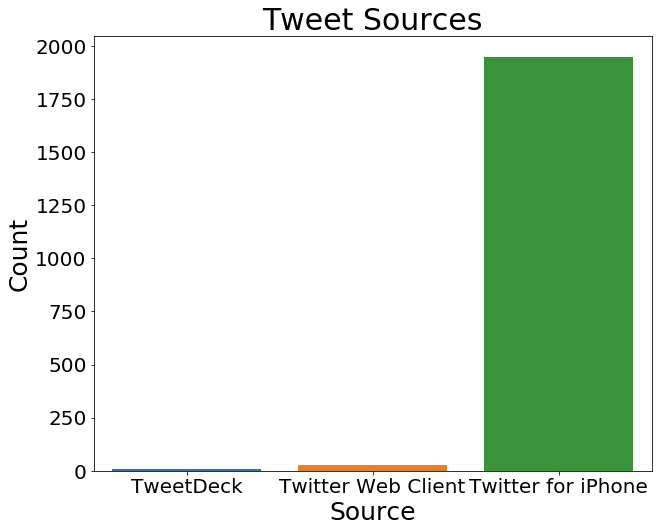

In [101]:
# Plotting tweet sources
# Utilized forum to adjust display https://stackoverflow.com/questions/36220829/fine-control-over-the-font-size-in-seaborn-plots-for-academic-papers
sns.countplot(data=df, x='source')
plt.title('Tweet Sources', size=30)
plt.xlabel('Source', size=25) 
plt.ylabel('Count', size=25)
plt.tick_params(labelsize=20)
plt.savefig('most_used_twitter_source')

The most popular source for users is Twitter for iPhone followed by Twitter Web Client and TweetDeck.

**What do the number of tweets look like on a monthly basis?**

In [102]:
# Display number of tweets per month by year
df['timestamp'].apply(lambda x: x.strftime('%Y-%m')).value_counts().sort_index()

2015-11    296
2015-12    366
2016-01    169
2016-02    111
2016-03    120
2016-04    54 
2016-05    57 
2016-06    81 
2016-07    87 
2016-08    59 
2016-09    62 
2016-10    65 
2016-11    53 
2016-12    54 
2017-01    66 
2017-02    63 
2017-03    46 
2017-04    41 
2017-05    43 
2017-06    43 
2017-07    49 
2017-08    2  
Name: timestamp, dtype: int64

In [103]:
df.describe()

,rating_denominator,rating_numerator_new,favorite_count,retweet_count,pred_confidence,fraction
count,1987.000000,1960.000000,1987.000000,1987.000000,1617.000000,1960.000000
mean,10.533971,12.266724,8216.672874,2434.139406,0.563573,1.168830
std,7.333532,41.817489,12096.542817,4354.696770,0.294766,4.099154
min,2.000000,0.000000,70.000000,11.000000,0.000001,0.000000
25%,10.000000,10.000000,1765.500000,543.500000,0.328161,1.000000
50%,10.000000,11.000000,3722.000000,1181.000000,0.573140,1.100000
75%,10.000000,12.000000,10212.000000,2769.500000,0.829058,1.200000
max,170.000000,1776.000000,155064.000000,77062.000000,0.999956,177.600000


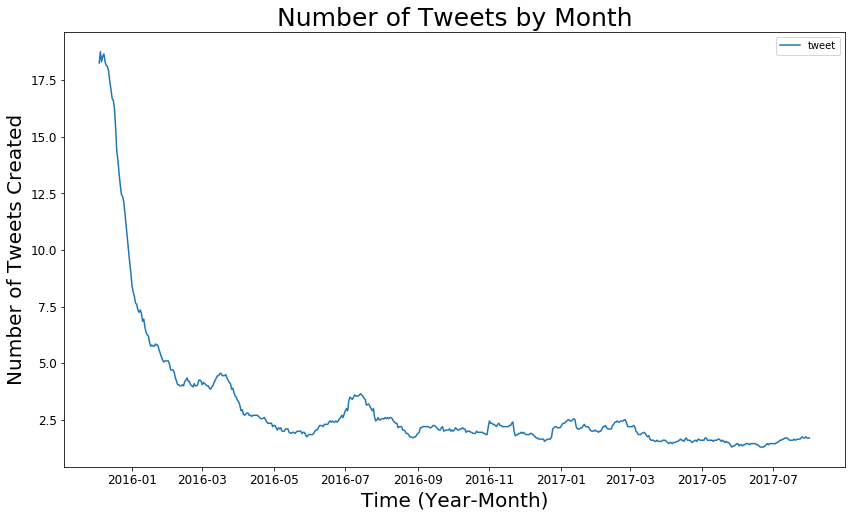

<Figure size 720x576 with 0 Axes>

In [104]:
# Plot number of tweets over time
# Create two columns: 'date' to aggregate 'datetime' and 'tweet' to sum number of tweets for a given date
df['date'] = df['timestamp'].dt.date
df['tweet'] = 1

# Create new dataframe sorted by date
df1 = df[['date', 'tweet']].groupby(['date']).sum() # alternatively .count() could be used

# Use moving averages to smooth the line
df1['tweet'] = df1['tweet'].rolling(window=20).mean()

# Plot
df1.plot(figsize=(14, 8), title='Tweets by Month')
plt.title('Number of Tweets by Month', size=25)
plt.ylabel('Number of Tweets Created', size=20)
plt.xlabel('Time (Year-Month)', size=20)
plt.tick_params(labelsize=12)
plt.show()
plt.savefig('number_of_tweets_over_time')

The greatest number of tweets created was in December 2015 with 366 new tweets. Since then the number of tweets have decreased and stayed relatively constant with occassional peaks seen in February-March and May-June of 2016 with an increase of 9 and 24 tweets respectively.

Text(0.5, 1.0, 'Distribution of the Rating Numerator')

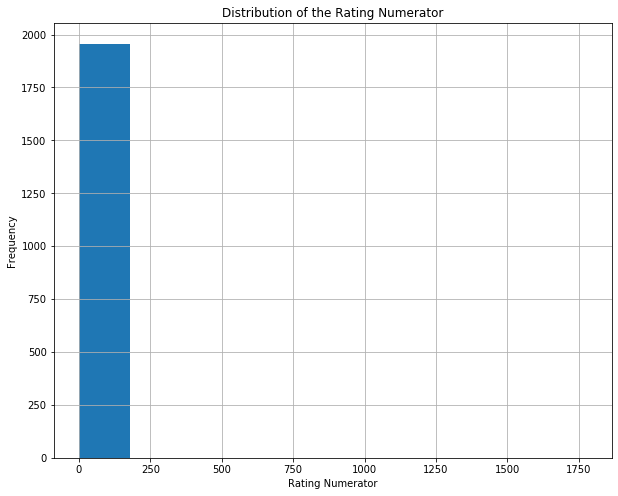

In [105]:
# Looking at histograms of variables
df.hist(column='rating_numerator_new')
plt.xlabel('Rating Numerator')
plt.ylabel('Frequency')
plt.title('Distribution of the Rating Numerator')

This histogram does not display the distribution well since 75% of the 'rating_numerator_new' data is 12 with a maximum value of 1,776.

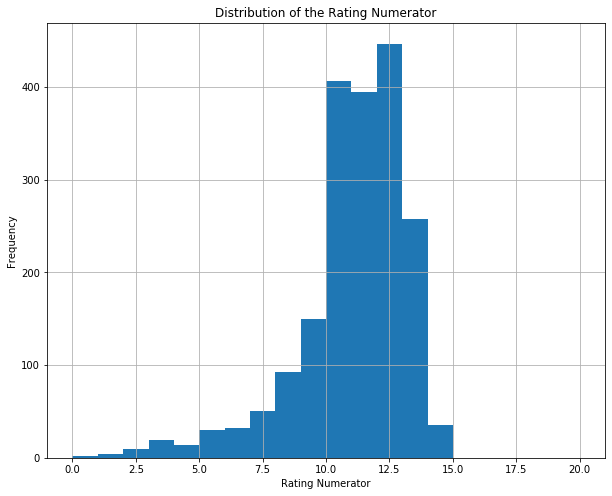

In [106]:
# Changing bins
df.hist(column='rating_numerator_new', bins = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
plt.xlabel('Rating Numerator')
plt.ylabel('Frequency')
plt.title('Distribution of the Rating Numerator')
plt.savefig('rating_numerator_dist');

Most rating numerators are between 10 and 12.

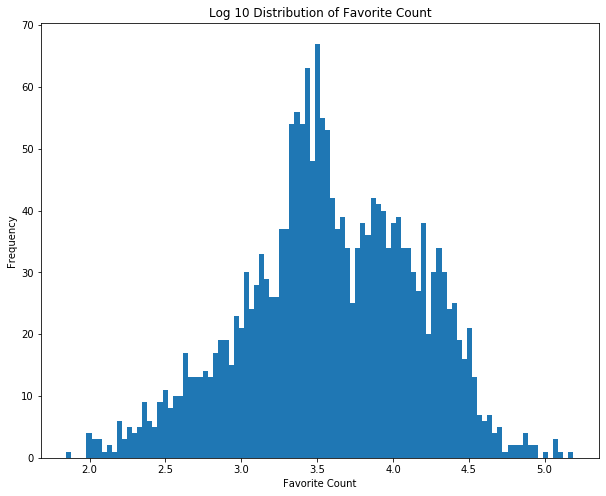

In [107]:
# Look at 'favorite_count' distribution
log_favorite = df['favorite_count'].apply(lambda x: np.log10(x))
plt.hist(log_favorite, bins=100)
plt.xlabel('Favorite Count')
plt.ylabel('Frequency')
plt.title('Log 10 Distribution of Favorite Count')
plt.savefig('favorite_count_dist');

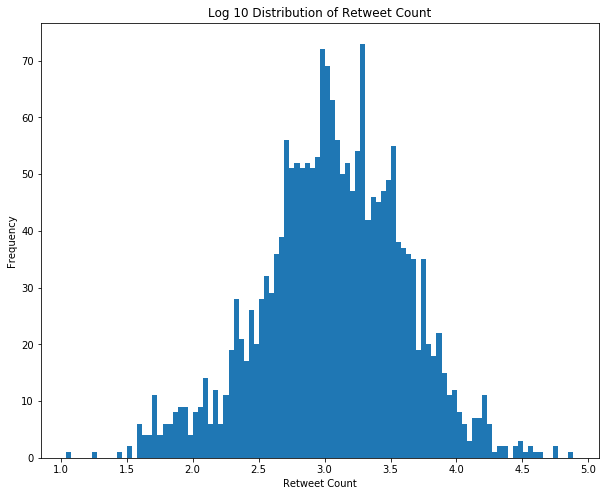

In [108]:
# Look at 'retweet_count' distribution
log_retweet = df['retweet_count'].apply(lambda x: np.log10(x))
plt.hist(log_retweet, bins=100)
plt.xlabel('Retweet Count')
plt.ylabel('Frequency')
plt.title('Log 10 Distribution of Retweet Count')
plt.savefig('retweet_count_dist');

Both 'favorite_count' and 'retweet_count' follow a normal distribution.

**What is the most common dog rating?**

In [109]:
df['rating_numerator_new'].value_counts().sort_index()

0.00       2  
1.00       4  
2.00       9  
3.00       19 
4.00       14 
5.00       30 
6.00       32 
7.00       50 
8.00       93 
9.00       149
9.75       1  
10.00      407
11.00      393
11.26      1  
11.27      1  
12.00      447
13.00      257
13.50      1  
14.00      35 
24.00      1  
44.00      1  
45.00      1  
60.00      1  
80.00      1  
84.00      1  
88.00      1  
99.00      1  
121.00     1  
143.00     1  
144.00     1  
165.00     1  
204.00     1  
420.00     1  
1776.00    1  
Name: rating_numerator_new, dtype: int64

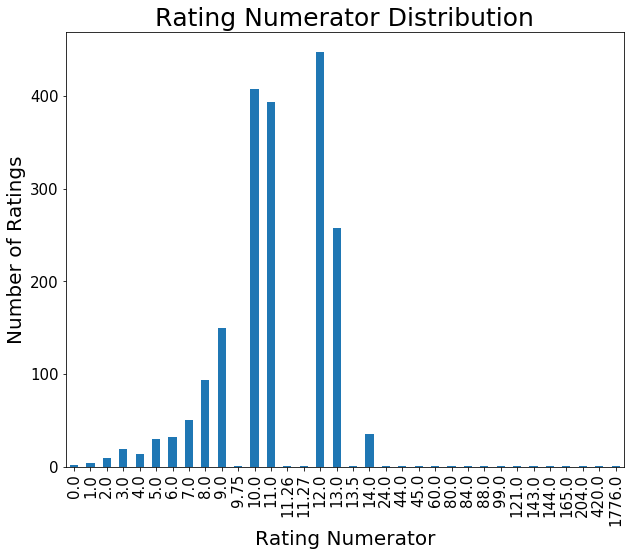

In [110]:
df['rating_numerator_new'].value_counts().sort_index().plot(kind='bar')
plt.title ('Rating Numerator Distribution', size=25)
plt.xlabel('Rating Numerator', size=20)
plt.ylabel('Number of Ratings', size=20)
plt.tick_params(labelsize=15)
plt.savefig('rating_numerator_distribution');

The most often assigned numerator is 12 with 447 dogs given a 12/10 rating.

**How many dog breeds were successfully predicted by the algorithm and how many failed?**

In [111]:
print('The algorithm predicted {} dog breeds and failed in {} cases.'.format(df['breed_pred'].value_counts().sum(), (df['breed_pred'].isnull().sum())))

The algorithm predicted 1617 dog breeds and failed in 370 cases.


**What are the 10 most frequent dog breeds?**

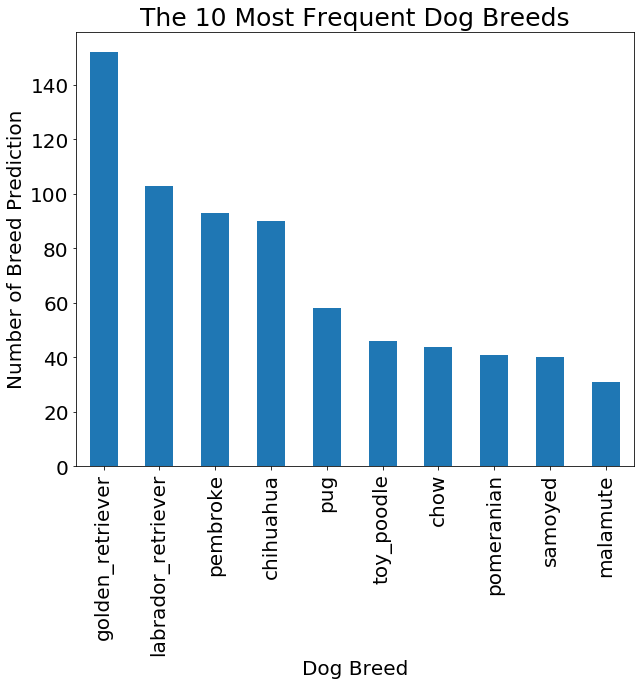

In [112]:
df['breed_pred'].value_counts()[0:10].sort_values(ascending=False).plot(kind = 'bar')
plt.title('The 10 Most Frequent Dog Breeds', size=25)
plt.xlabel('Dog Breed', size=20)
plt.ylabel('Number of Breed Prediction', size=20)
plt.tick_params(labelsize=20)
plt.savefig('most_frequent_breed');

In [113]:
df['breed_pred'].value_counts()[0:10]

golden_retriever      152
labrador_retriever    103
pembroke              93 
chihuahua             90 
pug                   58 
toy_poodle            46 
chow                  44 
pomeranian            41 
samoyed               40 
malamute              31 
Name: breed_pred, dtype: int64

**What is the algorithm confidence level for predicting the 10 most frequent dog breeds?**

In [114]:
# List of top 10 dog breeds
name_list = df['breed_pred'].value_counts()[0:10].index.tolist()
name_list

['golden_retriever',
 'labrador_retriever',
 'pembroke',
 'chihuahua',
 'pug',
 'toy_poodle',
 'chow',
 'pomeranian',
 'samoyed',
 'malamute']

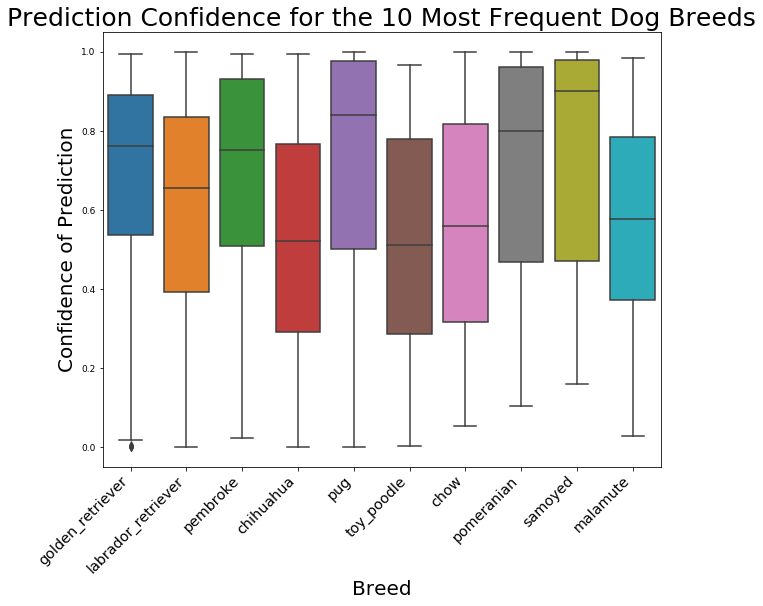

In [130]:
# Subset the DataFrame using name_list
df_subset = df[df['breed_pred'].isin(name_list)]

# Plot a boxplot 
sns.boxplot(x='breed_pred', y='pred_confidence', data=df_subset, order=name_list)
plt.title('Prediction Confidence for the 10 Most Frequent Dog Breeds', size=25)
plt.xlabel('Breed', size=20)
plt.ylabel('Confidence of Prediction', size=20)
plt.tick_params(labelsize=9)
plt.xticks(rotation=45, horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.savefig('prediction_confidence_top_10'); 

The prediction confidence varies between the 10 most frequent dog breeds. The algorithm is more confident in predictions for breeds like the samoyed, pomeranian, and pug. Less confident predictions near 50% can be seen with chihuahuas, toy poodles, and malamutes.

**What are the 10 most frequent dog names?**

In [117]:
df['names'].value_counts()[0:10].sort_values(ascending=False)

Oliver     10
Cooper     10
Charlie    10
Lucy       9 
Penny      9 
Tucker     9 
Sadie      8 
Winston    8 
Lola       7 
Daisy      7 
Name: names, dtype: int64

Cooper, Charlie, and Oliver are tied as the most frequent dog name 

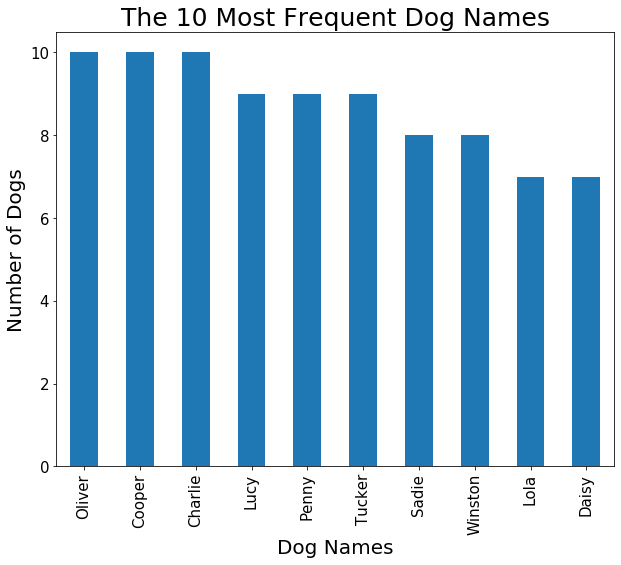

In [118]:
df['names'].value_counts()[0:10].sort_values(ascending=False).plot(kind = 'bar')
plt.title('The 10 Most Frequent Dog Names', size=25)
plt.xlabel('Dog Names', size=20)
plt.ylabel('Number of Dogs', size=20)
plt.tick_params(labelsize=15)
plt.savefig('most_frequent_names');

**How do dog names and ratings effect retweets and favorites?**

In [119]:
df.loc[:,['retweet_count','favorite_count']].describe()

,retweet_count,favorite_count
count,1987.000000,1987.000000
mean,2434.139406,8216.672874
std,4354.696770,12096.542817
min,11.000000,70.000000
25%,543.500000,1765.500000
50%,1181.000000,3722.000000
75%,2769.500000,10212.000000
max,77062.000000,155064.000000


In [120]:
# Number of retweets based on presence of dog name
print('The mean retweet count for dogs without a name present is', 
                  round(df.retweet_count[df.names.isnull()].mean()))
print('The mean retweet count for dogs with a name present is', 
                  round(df.retweet_count[df.names.notnull()].mean()))

# Number of favorites based on presence of dog name
print('The mean favorite count for dogs without a name present is', 
                  round(df.favorite_count[df.names.isnull()].mean()))
print('The mean favorite count for dogs with a name present is', 
                  round(df.favorite_count[df.names.notnull()].mean()))

The mean retweet count for dogs without a name present is 2612
The mean retweet count for dogs with a name present is 2353
The mean favorite count for dogs without a name present is 7751
The mean favorite count for dogs with a name present is 8430


Tweets that include a dog name are more likely to be favorited and less likely to be retweeted.

In [121]:
# Number of retweets based on rating numerator
print('The mean retweet count for dog rating numerators above 10 is {}.'.format
      (round(df.retweet_count[df.rating_numerator_new > 10].mean())))
print('The mean retweet count for dog rating numerators under 10 is {}.'.format
      (round(df.retweet_count[df.rating_numerator_new >= 10].mean())))

# Number of favorites based on rating numerator
print('The mean favorite count for dog rating numerators above 10 is {}.'.format
      (round(df.favorite_count[df.rating_numerator_new > 10].mean())))
print('The mean favorite count for dog rating numerators under 10 is {}.'.format
      (round(df.favorite_count[df.rating_numerator_new >= 10].mean())))

The mean retweet count for dog rating numerators above 10 is 3400.
The mean retweet count for dog rating numerators under 10 is 2858.
The mean favorite count for dog rating numerators above 10 is 11896.
The mean favorite count for dog rating numerators under 10 is 9775.


Tweets with dog ratings above 10 are more likely to be favorited and retweeted.

**How do the distributions for favorites and retweets compare?**

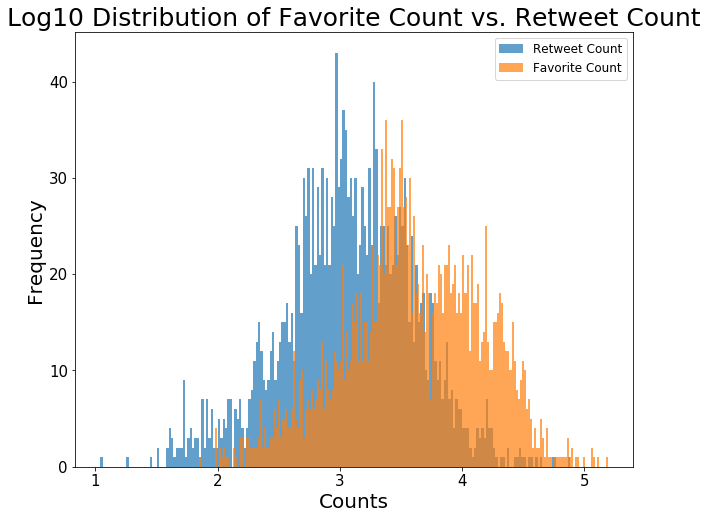

In [122]:
log_retweet = df['retweet_count'].apply(lambda x: np.log10(x))
log_favorite = df['favorite_count'].apply(lambda x: np.log10(x))
plt.hist(log_retweet, alpha=0.7, bins=200, label='Retweet Count')
plt.hist(log_favorite, alpha=0.7, bins=200, label='Favorite Count')
plt.title('Log10 Distribution of Favorite Count vs. Retweet Count', size=25)
plt.xlabel('Counts', size=20)
plt.ylabel('Frequency', size=20)
plt.tick_params(labelsize=15)
plt.legend(loc='upper right', fontsize=12)
plt.savefig('retweet_favorite_dist');

The distribution for favorite counts is skewed right when compared to retweet count suggesting that users favorite tweets more often than retweeting.

**What dog stage is reported most frequently?**

In [123]:
df['dog_stage'].value_counts()

pupper     222
doggo      70 
puppo      26 
floofer    7  
Name: dog_stage, dtype: int64

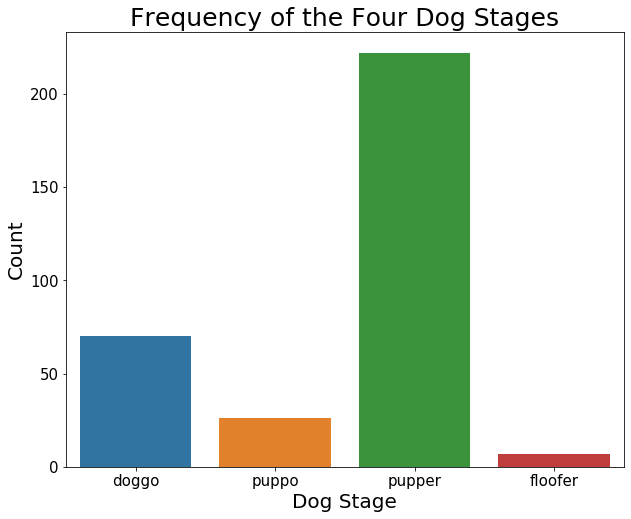

In [124]:
sns.countplot(data=df, x='dog_stage')
plt.title('Frequency of the Four Dog Stages', size=25)
plt.xlabel('Dog Stage', size=20)
plt.ylabel('Count', size=20)
plt.tick_params(labelsize=15)
plt.savefig('dog_stages');

Pupper is the most reported dog stage(222) followed by doggo(70), puppo(26) and floofer(7).

**What dog stage received the highest ratings?**

In [125]:
df.groupby('dog_stage')['fraction'].describe()

,count,mean,std,min,25%,50%,75%,max
dog_stage,,,,,,,,
doggo,70.0,1.165714,0.169300,0.5,1.10,1.2,1.3,1.4
floofer,7.0,1.200000,0.115470,1.0,1.15,1.2,1.3,1.3
pupper,220.0,1.061605,0.180904,0.3,1.00,1.1,1.2,1.4
puppo,26.0,1.207692,0.123038,0.9,1.20,1.2,1.3,1.4


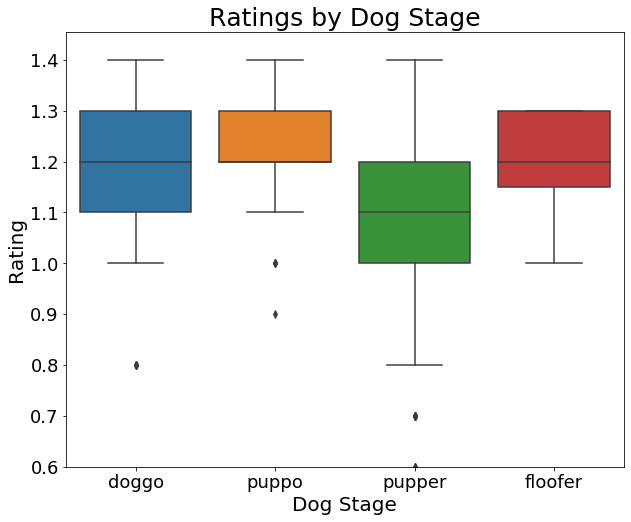

In [126]:
sns.boxplot(x='dog_stage', y='fraction', data=df)
plt.title('Ratings by Dog Stage', size=25)
plt.xlabel('Dog Stage', size=20)
plt.ylabel('Rating', size=20)
plt.tick_params(labelsize=18)
plt.ylim(0.6,)
plt.savefig('rating_dog_stage');

Puppos received the highest ratings. Although puppers appeared the most frequently, they have the lowest average ratings. 

**How are favorite and retweet counts effected by dog stages?**

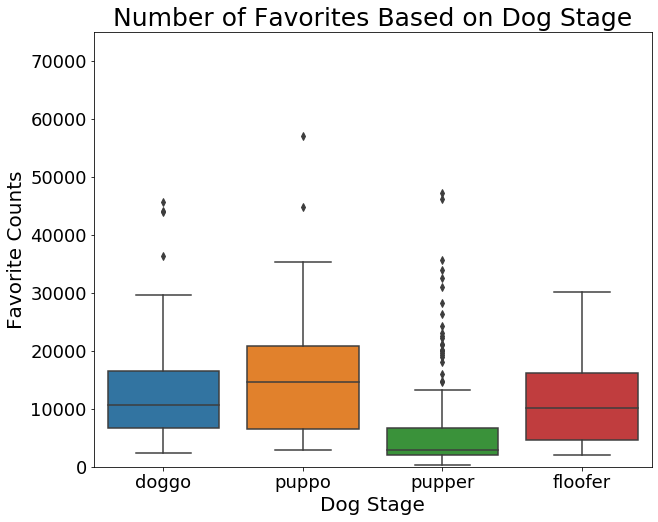

In [127]:
# Looking at favorites
sns.boxplot(x='dog_stage', y='favorite_count', data=df)
plt.title('Number of Favorites Based on Dog Stage', size=25)
plt.xlabel('Dog Stage', size=20)
plt.ylabel('Favorite Counts', size=20)
plt.ylim(0,75000)
plt.tick_params(labelsize=18)
plt.savefig('favorites_dog_stage');

Puppos are the most favorited dog stage. Puppers are the least number of favorites.

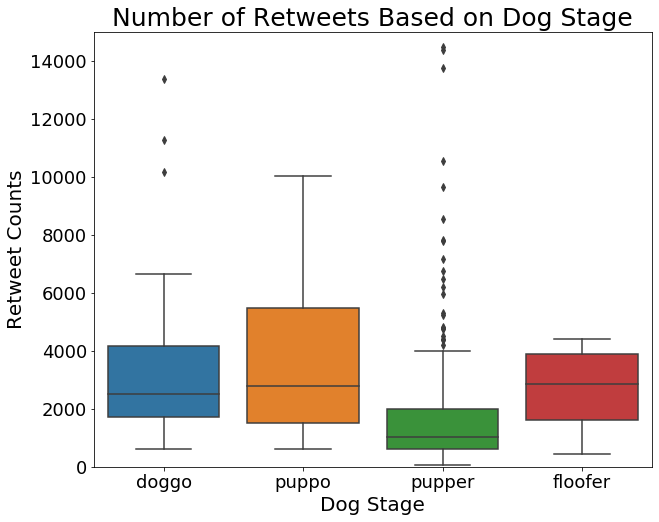

In [128]:
sns.boxplot(x='dog_stage', y='retweet_count', data=df)
plt.title('Number of Retweets Based on Dog Stage', size=25)
plt.xlabel('Dog Stage', size=20)
plt.ylabel('Retweet Counts', size=20)
plt.ylim(0,15000)
plt.tick_params(labelsize=18)
plt.savefig('retweets_dog_stage');

Floofers and puppos have the most retweets. Puppos are the least retweeted.

**How are all variables correlated?**

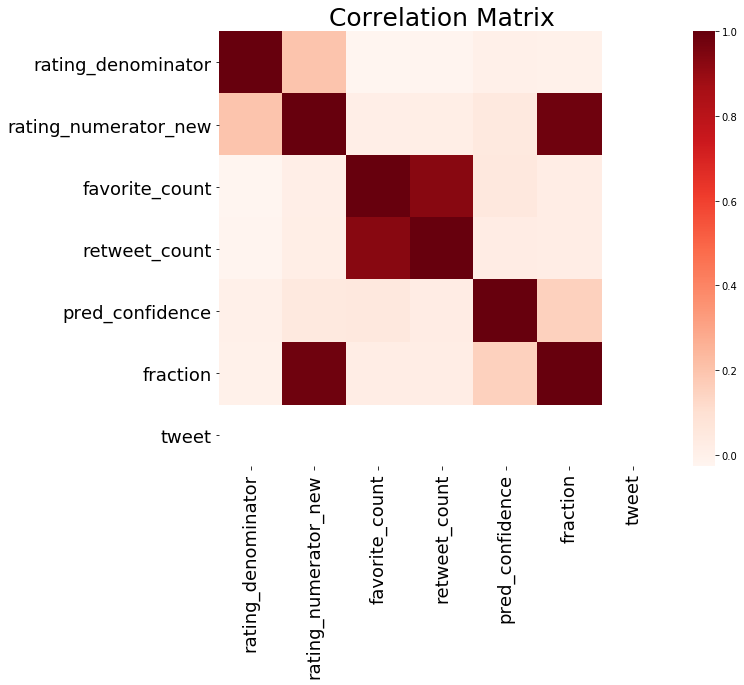

In [129]:
sns.heatmap(df.corr(), cmap="Reds")
plt.title('Correlation Matrix', size=25)
plt.tick_params(labelsize=18)
plt.savefig('heatmap');

The correlation matrix aligns with findings from the data exploration. The strong correlation between 'fraction' and 'rating_numerator_new' is expected since these variables are used for calculating correlation. The relationship between 'retweet_count' and 'favorite_count' was explored earlier in this analysis supports the strong correlation indicated in this matrix. The lack of correlation between remaining variables was also supported in the analysis.

<a id='sources'></a>
## Resources

* https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv

* https://developer.twitter.com/en/docs/basics/developer-portal/overview

* https://stackoverflow.com/questions/28384588/twitter-api-get-tweets-with-specific-id

* https://stackoverflow.com/questions/12309269/how-do-i-write-json-data-to-a-file

* https://stackoverflow.com/questions/19482970/get-list-from-pandas-dataframe-column-headers

* https://stackoverflow.com/questions/45184549/python-pandas-new-columns-value-if-the-item-is-in-the-list

* https://stackoverflow.com/questions/51782443/np-where-do-nothing-if-condition-fails

* https://stackoverflow.com/questions/35919907/replace-some-specific-values-in-pandas-column-based-on-conditions-in-other-colum

* https://stackoverflow.com/questions/42574379/python-sorting-dates-after-counting-them-in-pandas

* https://stackoverflow.com/questions/36220829/fine-control-over-the-font-size-in-seaborn-plots-for-academic-papers

* https://www.tweepy.org/

* https://twitter.com/dog_rates?lang=en

* https://www.udacity.com/course/data-analyst-nanodegree--nd002
